# Sequential x amortized inference

In this notebook, we will analyse the performance of Simulation-based inference algorithms in estimating the posterior distribution of the parameters defined in the Two Moons model.

## The Two Moons model

The parameters $\boldsymbol{\theta} \in \mathbb{R}^2$ are sampled from

$$ \theta_1 \sim \mathcal{U}([-1, 1])$$

$$ \theta_2 \sim \mathcal{U}([-1, 1])$$

The data $\boldsymbol{x} \in \mathbb{R}^2$ are generated as follows:

- Sample the latent variables 

$$\alpha \sim \mathcal{U}([-\pi/2, \pi/2])$$ 

$$r \sim \mathcal{N}(\mu=0.1, \sigma=0.01)$$

- Define $$p = (r \cos \alpha + 0.25, r \sin \alpha)$$

- Output $$\boldsymbol{x} = p - \left(\frac{|\theta_1 + \theta_2|}{\sqrt{2}}, \frac{\theta_1 - \theta_2}{\sqrt{2}} \right)$$

The name of the model comes from the shape of the posterior distribution $p(\boldsymbol{\theta} | \boldsymbol{x})$: bimodal with a banana-shaped mass around the modes (a-la a crescent moon).


In [1]:
import sys

sys.path.append("..")

import torch
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
import arviz as az
from sbi import analysis as analysis
from sbi import utils as utils

from sbisandbox.benchmarks import TwoMoonsBenchmark
from sbisandbox.runners import SNPERunner, SNRERunner

%matplotlib
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-whitegrid")

/Users/bernardoveronese/miniconda3/envs/sbibench/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
two_moons = TwoMoonsBenchmark()
seed = 1998

The `TwoMoonsBenchmark` class has built-in methods for the prior and the simulator $\boldsymbol{x} | \boldsymbol{\theta}$ of the two moons model. Let us generate observations of $(\boldsymbol{\theta}, \boldsymbol{x})$ and visualize them as 2D histograms:

In [3]:
# Check prior, return PyTorch prior.
num_observations = 1000
theta, x = two_moons.get_observations(
    num_observations=num_observations, seed=seed, simulation_batch_size=None
)

/var/folders/0p/lb2wpb5n0y7ggth5yzlvh_r80000gn/T/ipykernel_28488/4179056188.py:8: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


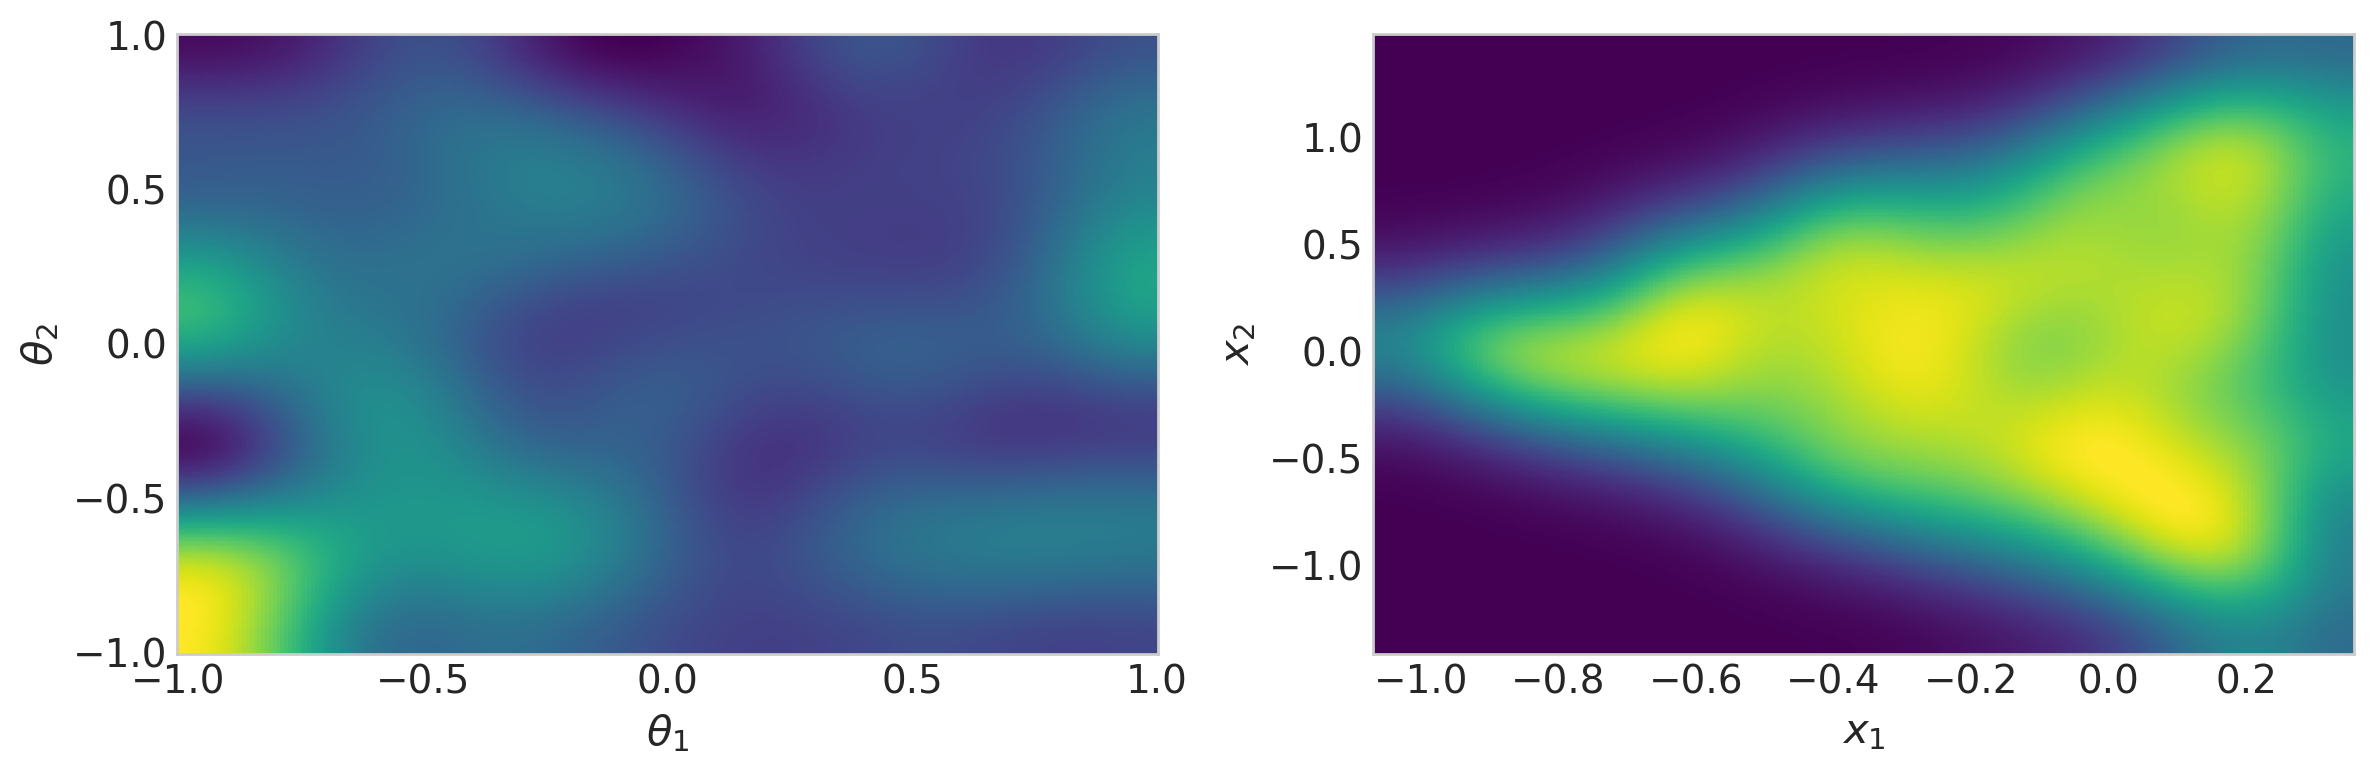

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
theta = theta.detach().numpy()
x = x.detach().numpy()
az.plot_kde(theta[:, 0], theta[:, 1], contour=False, ax=ax1)
az.plot_dist(x[:, 0], x[:, 1], contour=False, ax=ax2)
ax1.set(xlabel="$\\theta_1$", ylabel="$\\theta_2$")
ax2.set(xlabel="$x_1$", ylabel="$x_2$")
fig.tight_layout()
plt.show()

We observe that the distribution for $\boldsymbol{x}$ has this rather triangular shape. We can have a quantitative understanding of this behaviour by calculating the likelihood function explicitly (or the posterior, rather, since the prior $p(\boldsymbol{\theta})$ is a constant).

\begin{align*}
p(\boldsymbol{\theta} | \boldsymbol{x}) &= p(\boldsymbol{x} | \boldsymbol{\theta}) p(\boldsymbol{\theta})\\
&= p(\boldsymbol{\theta}) \int p(\boldsymbol{x}, r, \alpha | \boldsymbol{\theta})  dr \, d\alpha\\
&= p(\boldsymbol{\theta})\int p(\boldsymbol{x} | r, \alpha, \boldsymbol{\theta}) p(r, \alpha | \boldsymbol{\theta}) dr \, d\alpha\\
&= p(\boldsymbol{\theta})\int \delta(\boldsymbol{x} - \boldsymbol{x}(r, \alpha, \boldsymbol{\theta})) p(r) p(\alpha) dr \, d\alpha\\
\end{align*}

The delta function over $\mathbb{R}^2$ will fix both values of $r$ and $\alpha$ to the solution of

$$ \boldsymbol{x}(r, \alpha, \boldsymbol{\theta}) = \boldsymbol{x},$$

where $\boldsymbol{\theta}$ and $\boldsymbol{x}$ are given, and $\boldsymbol{x}(r, \alpha, \boldsymbol{\theta})$ indicates the functional form of $\boldsymbol{x}$ as a function of the other variables. Hence, we find the posterior to be

\begin{equation*}
 p(\boldsymbol{\theta} | \boldsymbol{x})= \begin{cases}
 \frac{1}{4} \frac{1}{\pi} \frac{1}{\sqrt{2 \pi} 0.01} \exp \left\{ -\frac{1}{2} \left( \frac{r(\boldsymbol{\theta}, \boldsymbol{x}) - 0.1}{0.01} \right)^2 \right\}, & \text{if } |\theta_1 + \theta_2| \geq \sqrt{2} (0.25 - x_1),\\
0, & \text{if } |\theta_1 + \theta_2| < \sqrt{2} (0.25 - x_1),
\end{cases}
\end{equation*}

where

$$ r(\boldsymbol{\theta}, \boldsymbol{x}) = \text{sgn} \left(|\theta_1 + \theta_2| - \sqrt{2} (0.25 - x_1) \right) \sqrt{\left(x_1  - 0.25 + \frac{|\theta_1 + \theta_2|}{\sqrt{2}}\right)^2 + \left(x_2 + \frac{\theta_1 - \theta_2}{\sqrt{2}}\right)^2}$$

The region $|\theta_1 + \theta_2| < \sqrt{2} (0.25 - x_1)$ corresponds to a solution with $\cos \alpha < 0$, which is not possible for $\alpha \in (-\pi/2, \pi/2)$, thereby reducing the posterior support on $\boldsymbol{\theta}$.

We now consider the observation $\boldsymbol{x}_0 = (0, 0)$, and plot the posterior $p(\boldsymbol{\theta} | \boldsymbol{x}_0)$ below.

In [5]:
def r_of_theta_x(theta1, theta2, x):
    x1, x2 = x
    plus = np.abs(theta1 + theta2) / np.sqrt(2)
    minus = (theta1 - theta2) / np.sqrt(2)
    rsin = x2 + minus
    rcos = x1 - 0.25 + plus
    sign_r = np.where(rcos >= 0, 1, -1)
    return sign_r * np.sqrt(rsin**2 + rcos**2)


def p_theta_given_x(theta1, theta2, x):
    x1, x2 = x
    plus = np.abs(theta1 + theta2) / np.sqrt(2)
    minus = (theta1 - theta2) / np.sqrt(2)
    rsin = x2 + minus
    rcos = x1 - 0.25 + plus
    sign_r = np.where(rcos >= 0, 1, -1)
    r = sign_r * np.sqrt(rsin**2 + rcos**2)
    chi = (r - 0.1) / 0.01
    norm = 1.0 / (4 * np.pi * np.sqrt(2 * np.pi) * 0.01)
    prob = norm * np.exp(-0.5 * chi**2)
    prob[rcos * sign_r < 0] = 0.0
    return prob

/var/folders/0p/lb2wpb5n0y7ggth5yzlvh_r80000gn/T/ipykernel_28488/4249240626.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


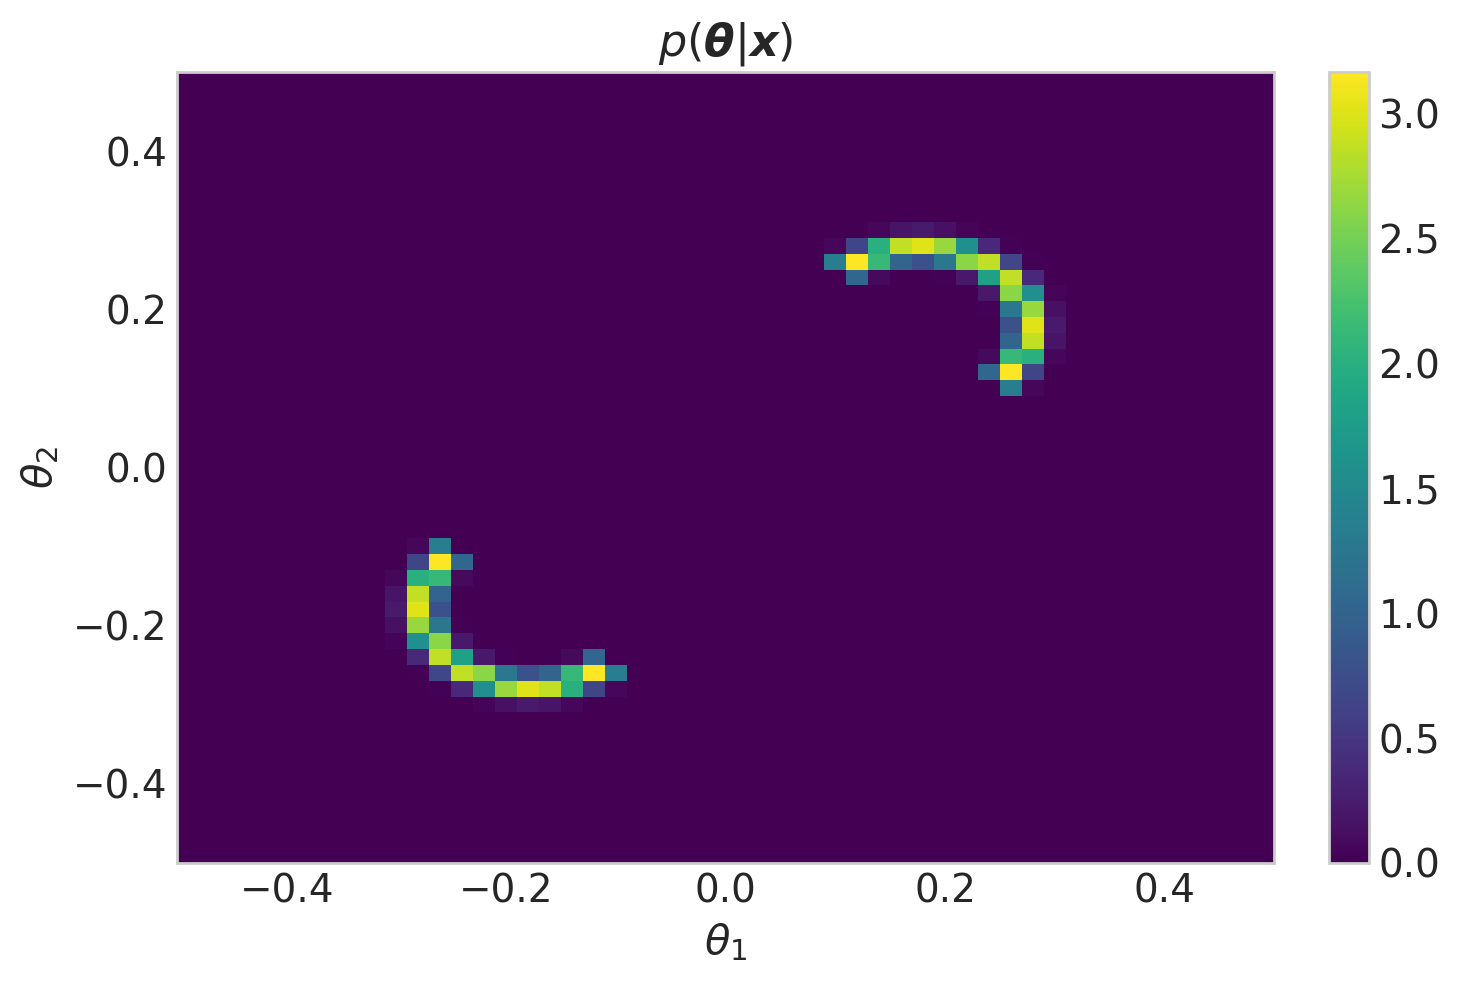

In [6]:
N = 100
theta1 = np.linspace(-1, 1, N + 1)
theta2 = np.linspace(-1, 1, N + 1)
x0 = np.zeros(2)

fig, ax = plt.subplots()
tt1, tt2 = np.meshgrid(theta1, theta2)
r = r_of_theta_x(tt1, tt2, x0)
a = 0.25
ax.scatter([-a, a], [-a, a], color="w")
im = ax.pcolormesh(tt1, tt2, p_theta_given_x(tt1, tt2, x0), antialiased=True)
fig.colorbar(im, ax=ax)

ax_kwargs = {
    "xlabel": "$\\theta_1$",
    "ylabel": "$\\theta_2$",
    "xlim": [-0.5, 0.5],
    "ylim": [-0.5, 0.5],
    "title": "$p(\\boldsymbol{\\theta} | \\boldsymbol{x})$",
}

ax.set(**ax_kwargs)
# fig.tight_layout()
fig.show()

The posterior is found to concentrate most of its mass in two disjoint, banana-shaped regions. The density resembles two crescent moons facing each other, hence the name of the model.

From the figure, it is clear that the effective support of the posterior is much smaller relative to the prior support $[0,1]^2$. Besides, from the fact that the two moons are separated by a (much larger) region of low posterior mass, we expect the performance of an MCMC to be very sensitive to the initialization strategy of the chains and the step size of the method.

To gather reference samples from the posterior, we implement below a simple Metropolis-Hastings algorithm with the independent proposal distribution

$$ \boldsymbol{\theta}' | \boldsymbol{\theta} \sim 0.5\mathcal{N}(p_1, \sigma) + 0.5\mathcal{N}(p_2, \sigma),$$

where $p_1 = (0.25, 0.25)$ and $p_2 = (-0.25, -0.25)$ approximate the curvature center of the moons, and $\sigma$ is fixed. With this choice of proposal, we expect to directly target the regions of concentrated posterior mass.


In [7]:
from torch.distributions import MultivariateNormal


def within_support(theta):
    return np.abs(np.sum(theta, axis=-1)) > np.sqrt(2) * 0.25


def sample_from_proposal(num_samples: int, num_chains: int, sigma: float):
    p = 0.25
    p1 = p * torch.ones(2)
    p2 = -p * torch.ones(2)
    cov = sigma * torch.eye(2)
    dist_high = MultivariateNormal(p1, cov)
    dist_low = MultivariateNormal(p2, cov)
    u = torch.rand((num_samples, num_chains)).unsqueeze(-1)
    high_samples = dist_high.sample((num_samples, num_chains))
    low_samples = dist_low.sample((num_samples, num_chains))
    return torch.where(u > 0.5, high_samples, low_samples).numpy()


def logp_theta_of_x0(theta):
    r = r_of_theta_x(theta[..., 0], theta[..., 1], x0)
    return -0.5 * (r - 0.1) ** 2 / 0.01**2


def naive_hastings(
    num_samples: int, theta0: ArrayLike, num_chains: int = 1, sigma: float = 0.1
):
    logu = np.log(np.random.rand(num_samples, num_chains))
    chains = np.empty((num_samples, num_chains, 2))
    chains[0, ...] = theta0
    proposal_samples = sample_from_proposal(num_samples, num_chains, sigma)
    logp_samples = logp_theta_of_x0(proposal_samples)
    chains_within_support = within_support(proposal_samples)
    current_logp = logp_theta_of_x0(theta0)
    acceptance_prob = np.empty((num_samples, num_chains))
    for i in range(1, num_samples):
        old = chains[i - 1, ...]
        target = proposal_samples[i, ...]
        log_alpha = logp_samples[i, :] - current_logp
        condition = chains_within_support[i, :] & (log_alpha > logu[i, :])
        acceptance_prob[i, :] = condition.astype(int)
        current_logp = np.where(condition, logp_samples[i, :], current_logp)
        chains[i, :] = np.where(condition[:, None], target, old)

    acceptance_prob = (
        acceptance_prob.cumsum(axis=0) / np.arange(1, num_samples + 1)[:, np.newaxis]
    )

    # Swap (sample, chain) by (chain, sample)
    return chains.swapaxes(0, 1), acceptance_prob

In [8]:
num_samples = 100000
num_chains = 5
sigma = 0.1 * 1.51
theta0 = sample_from_proposal(1, num_chains, sigma).squeeze()
samples_from_mcmc, acceptance_prob = naive_hastings(
    num_samples, theta0, num_chains, sigma
)

Our implementation takes very few seconds to generate the samples. Let us plot some diagnostics for the chains.

/var/folders/0p/lb2wpb5n0y7ggth5yzlvh_r80000gn/T/ipykernel_28488/2498186862.py:4: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/0p/lb2wpb5n0y7ggth5yzlvh_r80000gn/T/ipykernel_28488/2498186862.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


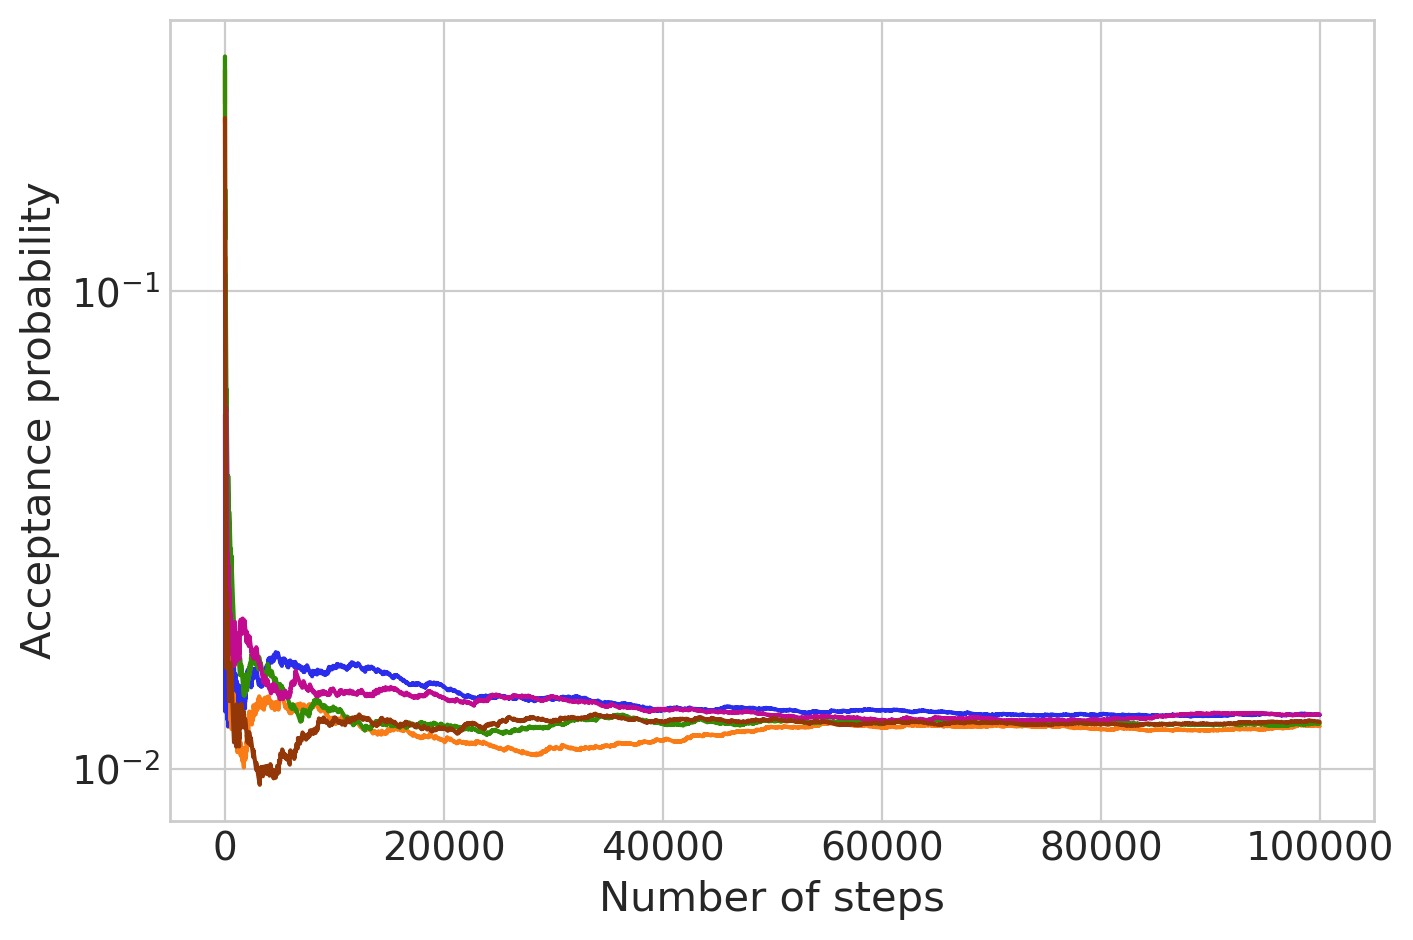

In [9]:
fig, ax = plt.subplots()
ax.plot(acceptance_prob[10:, :])
ax.set(xlabel="Number of steps", ylabel="Acceptance probability", yscale="log")
fig.tight_layout()
fig.show()

A very low and virtually constant acceptance probability is not surprising, given the choice of an independent proposal distribution with limited overlap with the true posterior mass.

In the cell below, we plot other diagnostic visualization tools built into [`arviz`](https://python.arviz.org/en/stable/index.html).

array([<Axes: title={'center': '$\\theta_1$'}, xlabel='Total number of draws', ylabel='Relative ESS'>,
       <Axes: title={'center': '$\\theta_2$'}, xlabel='Total number of draws', ylabel='Relative ESS'>],
      dtype=object)

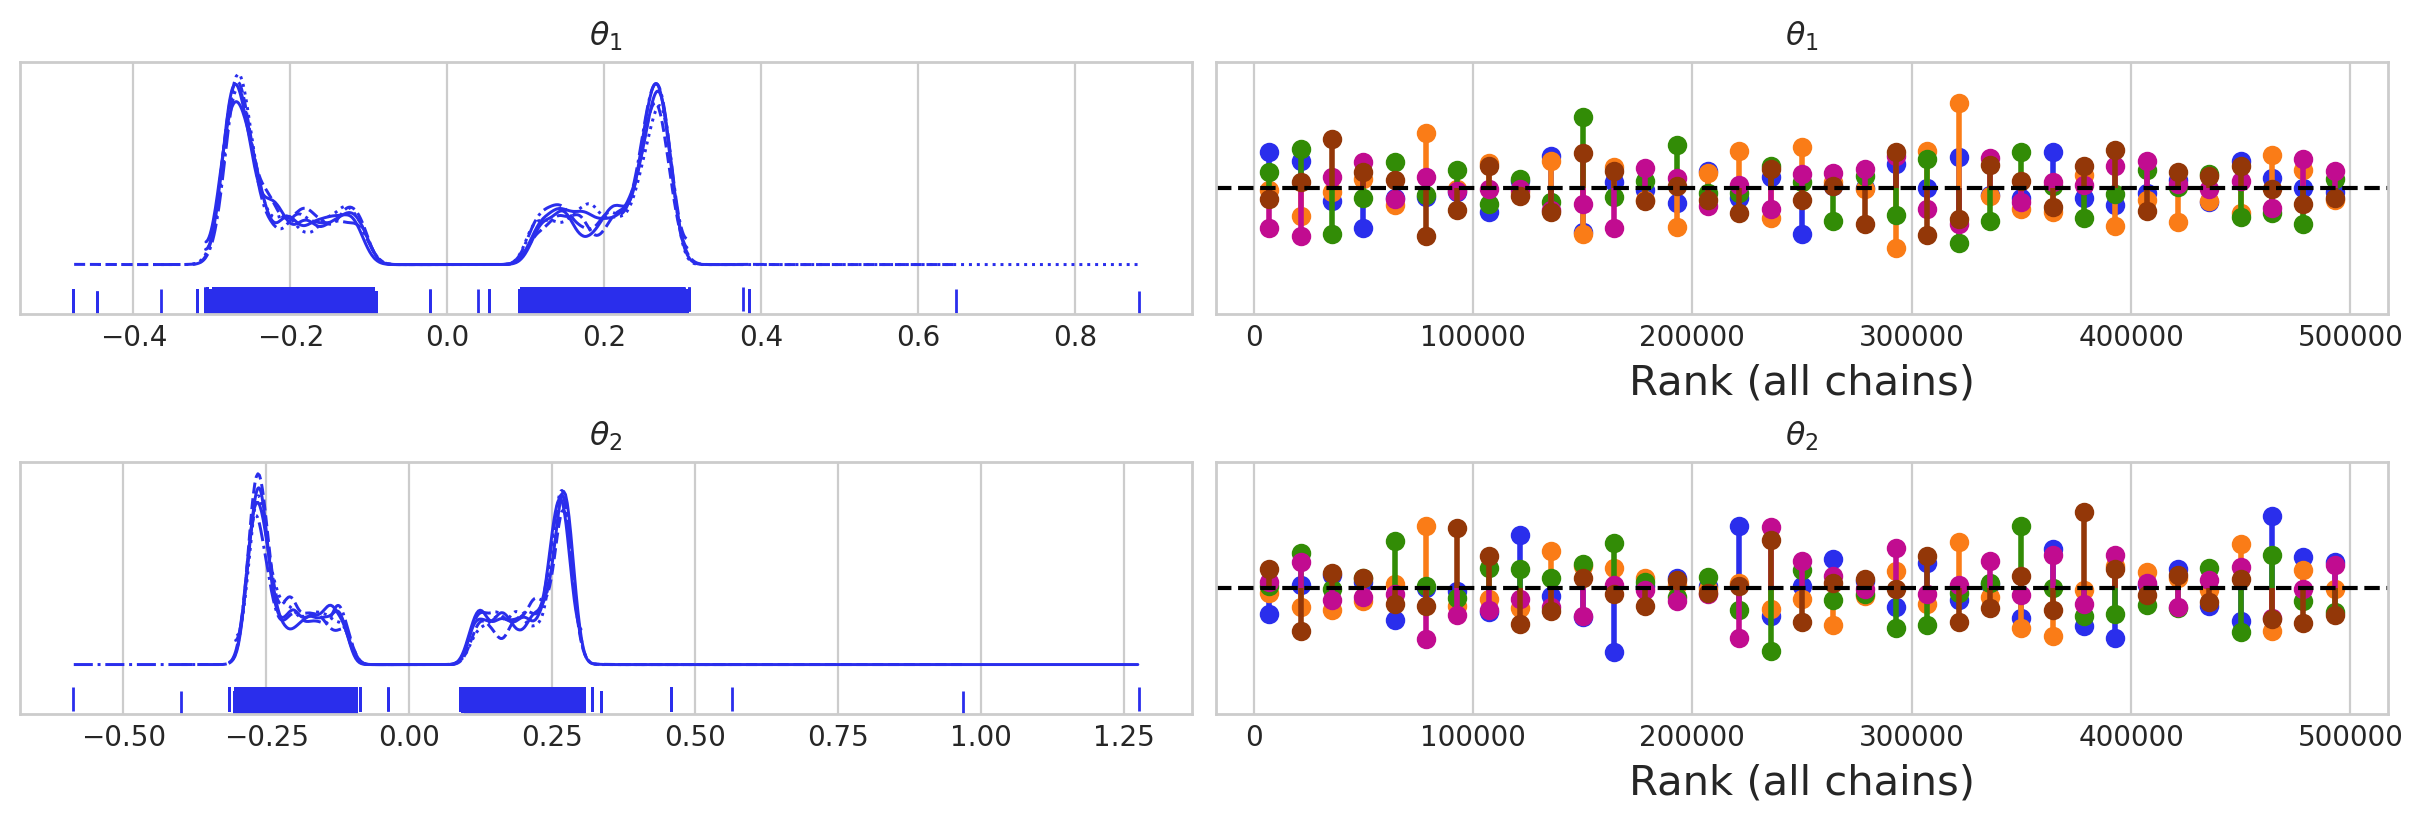

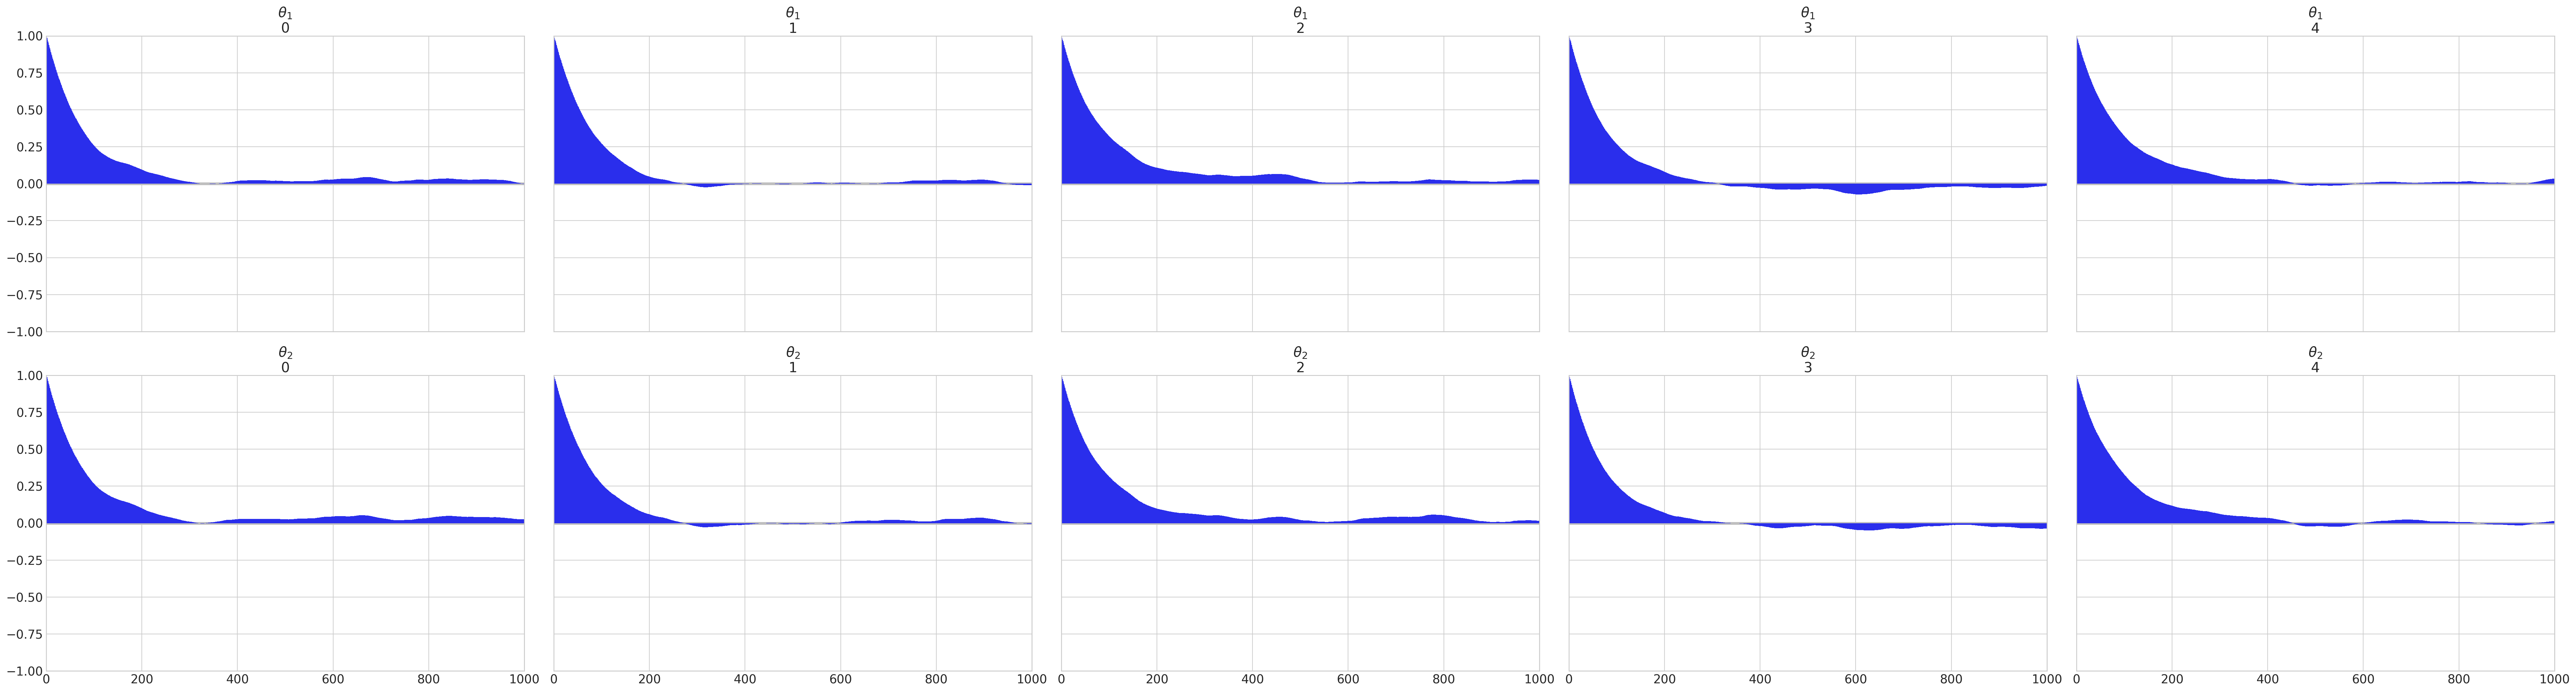

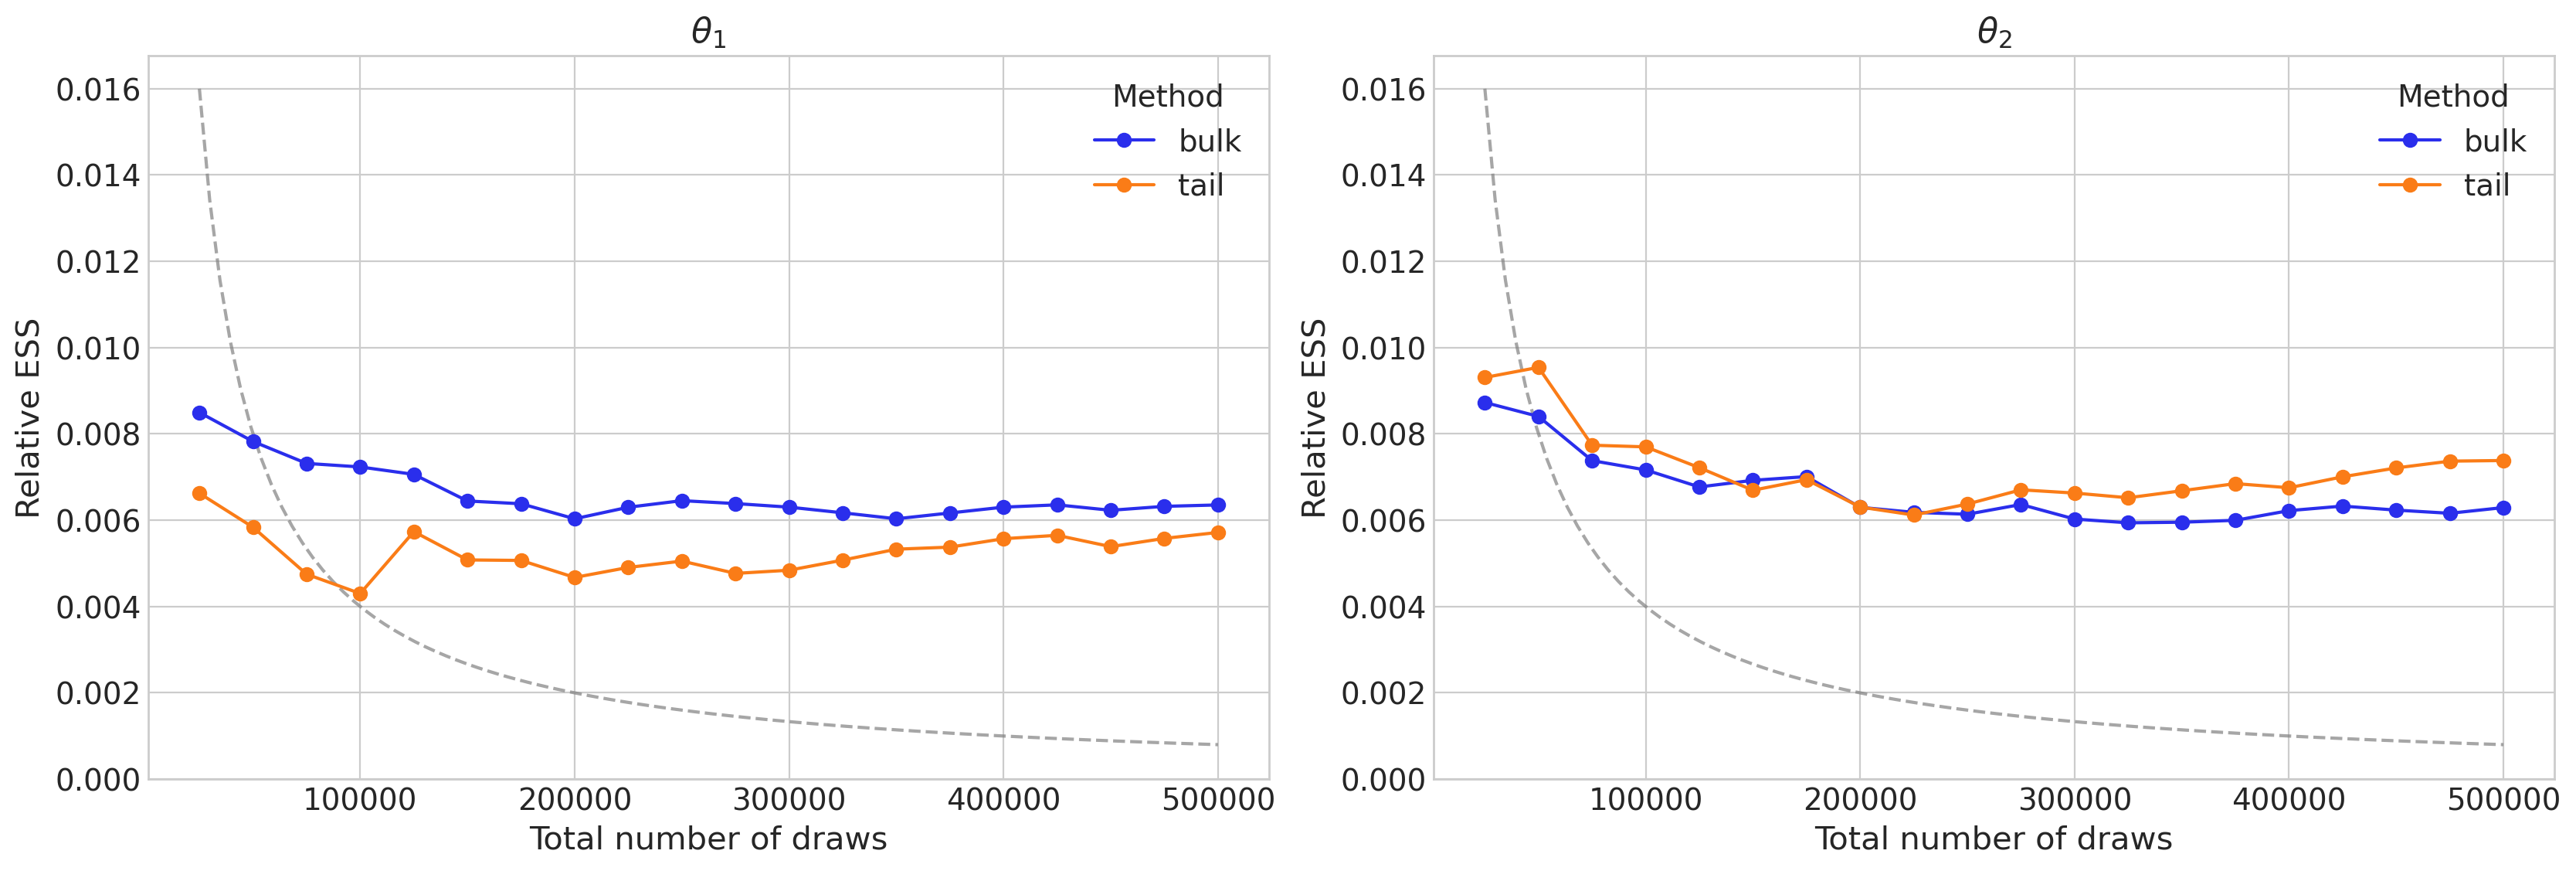

In [10]:
labels = ["$\\theta_1$", "$\\theta_2$"]


def get_data(samples, warmup: int = 0, thin: int = 1):
    data = (samples[:, warmup::thin, 0], samples[:, warmup::thin, 1])
    return dict(zip(labels, data))


data_from_mcmc = get_data(samples_from_mcmc)
az.plot_trace(data_from_mcmc, var_names=labels, rug=True, kind="rank_vlines")
az.plot_autocorr(data_from_mcmc, var_names=labels, grid=(2, 5), max_lag=1000)
az.plot_ess(
    data_from_mcmc,
    var_names=labels,
    relative=True,
    kind="evolution",
    extra_methods=True,
)

Again, we observe a similar behaviour for the autocorrelation across the chains. The relative effective sample size seems to stay constant at about 8%.


Finally, we visualize our samples in a corner plot, discarding 1000 warmup steps.

array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

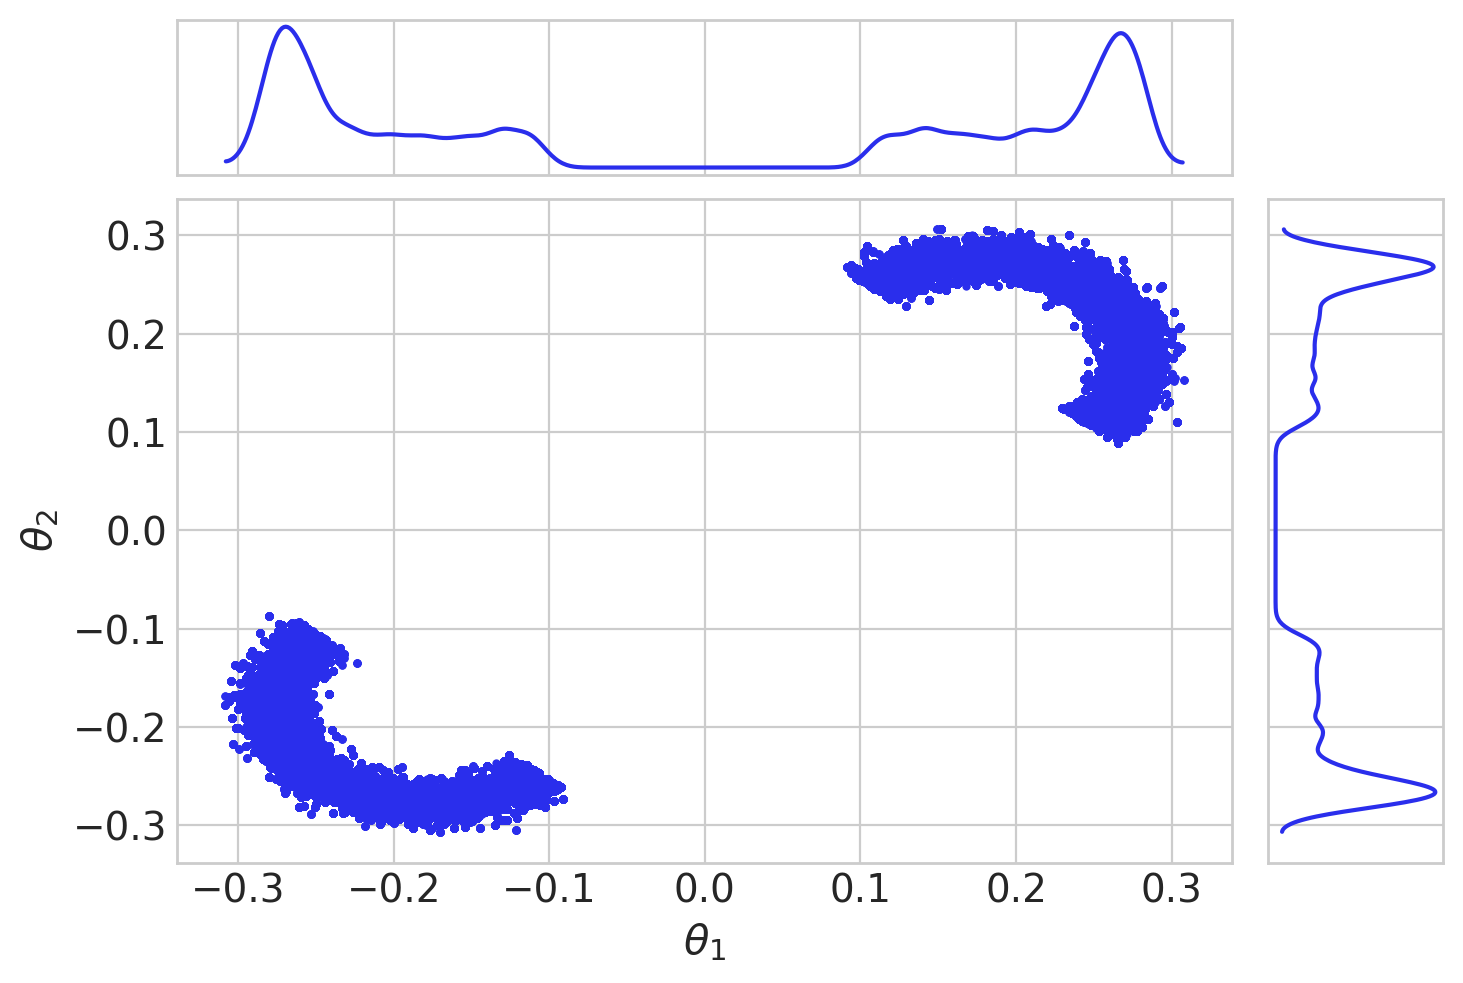

In [11]:
data_from_mcmc_trimmed = get_data(samples_from_mcmc, warmup=1000)
az.plot_pair(data_from_mcmc_trimmed, var_names=labels, marginals=True)

Let us compare these results with samples from the true posterior, which we obtain from explicitly inverting the simulator.

array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

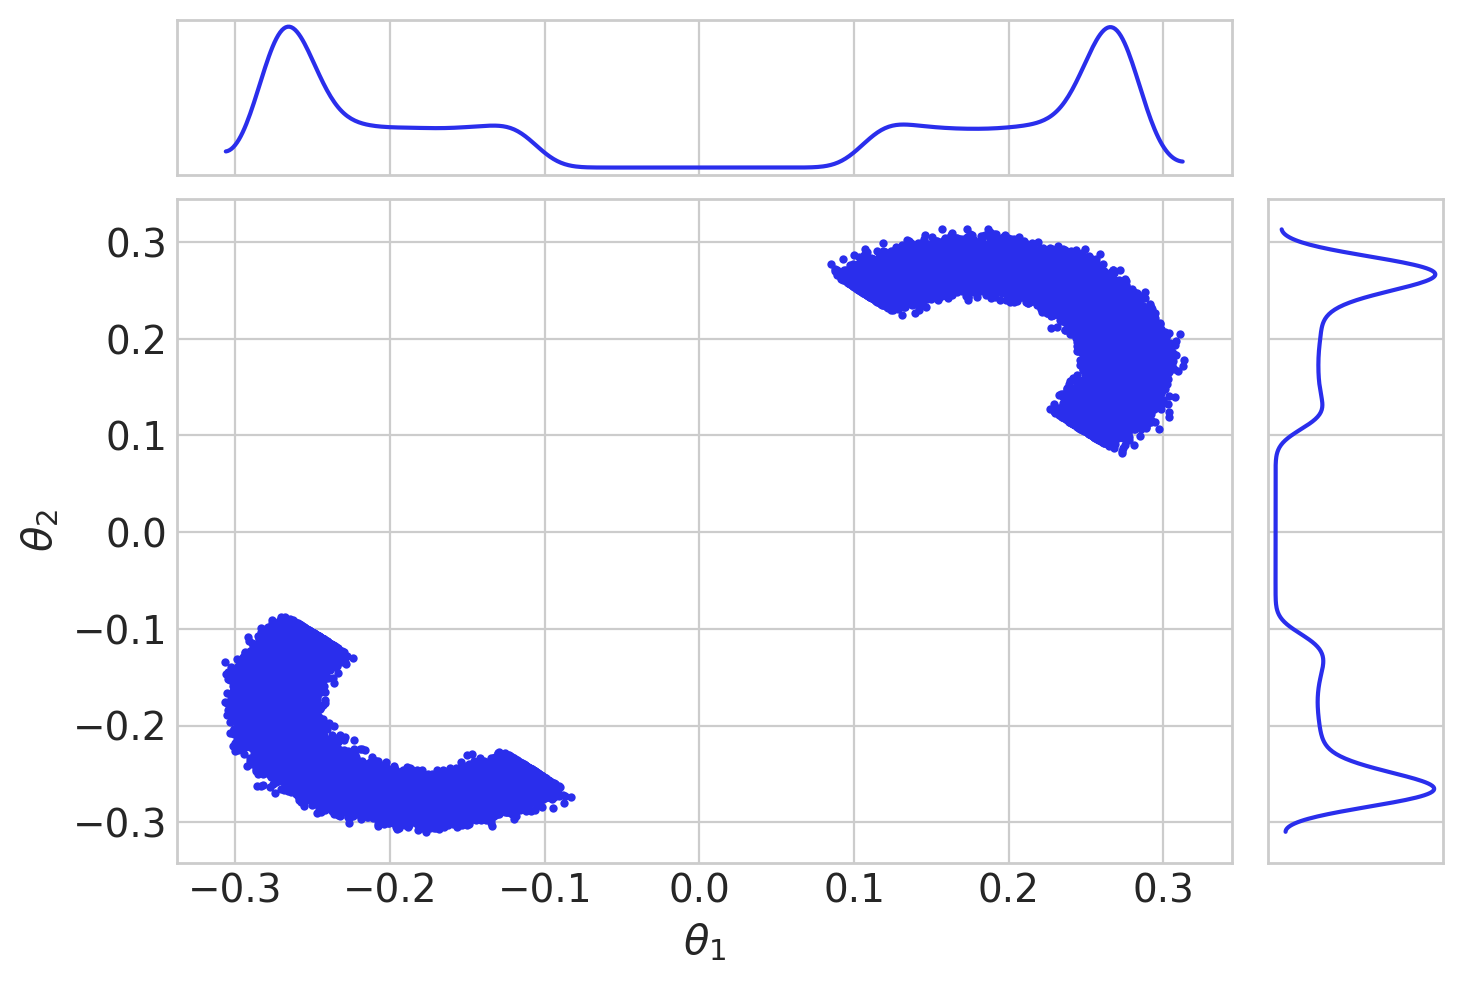

In [12]:
true_samples = two_moons.get_posterior_samples((num_samples,), torch.zeros(2))
data_from_true_samples = get_data(true_samples.unsqueeze(0))
az.plot_pair(data_from_true_samples, var_names=labels, marginals=True)

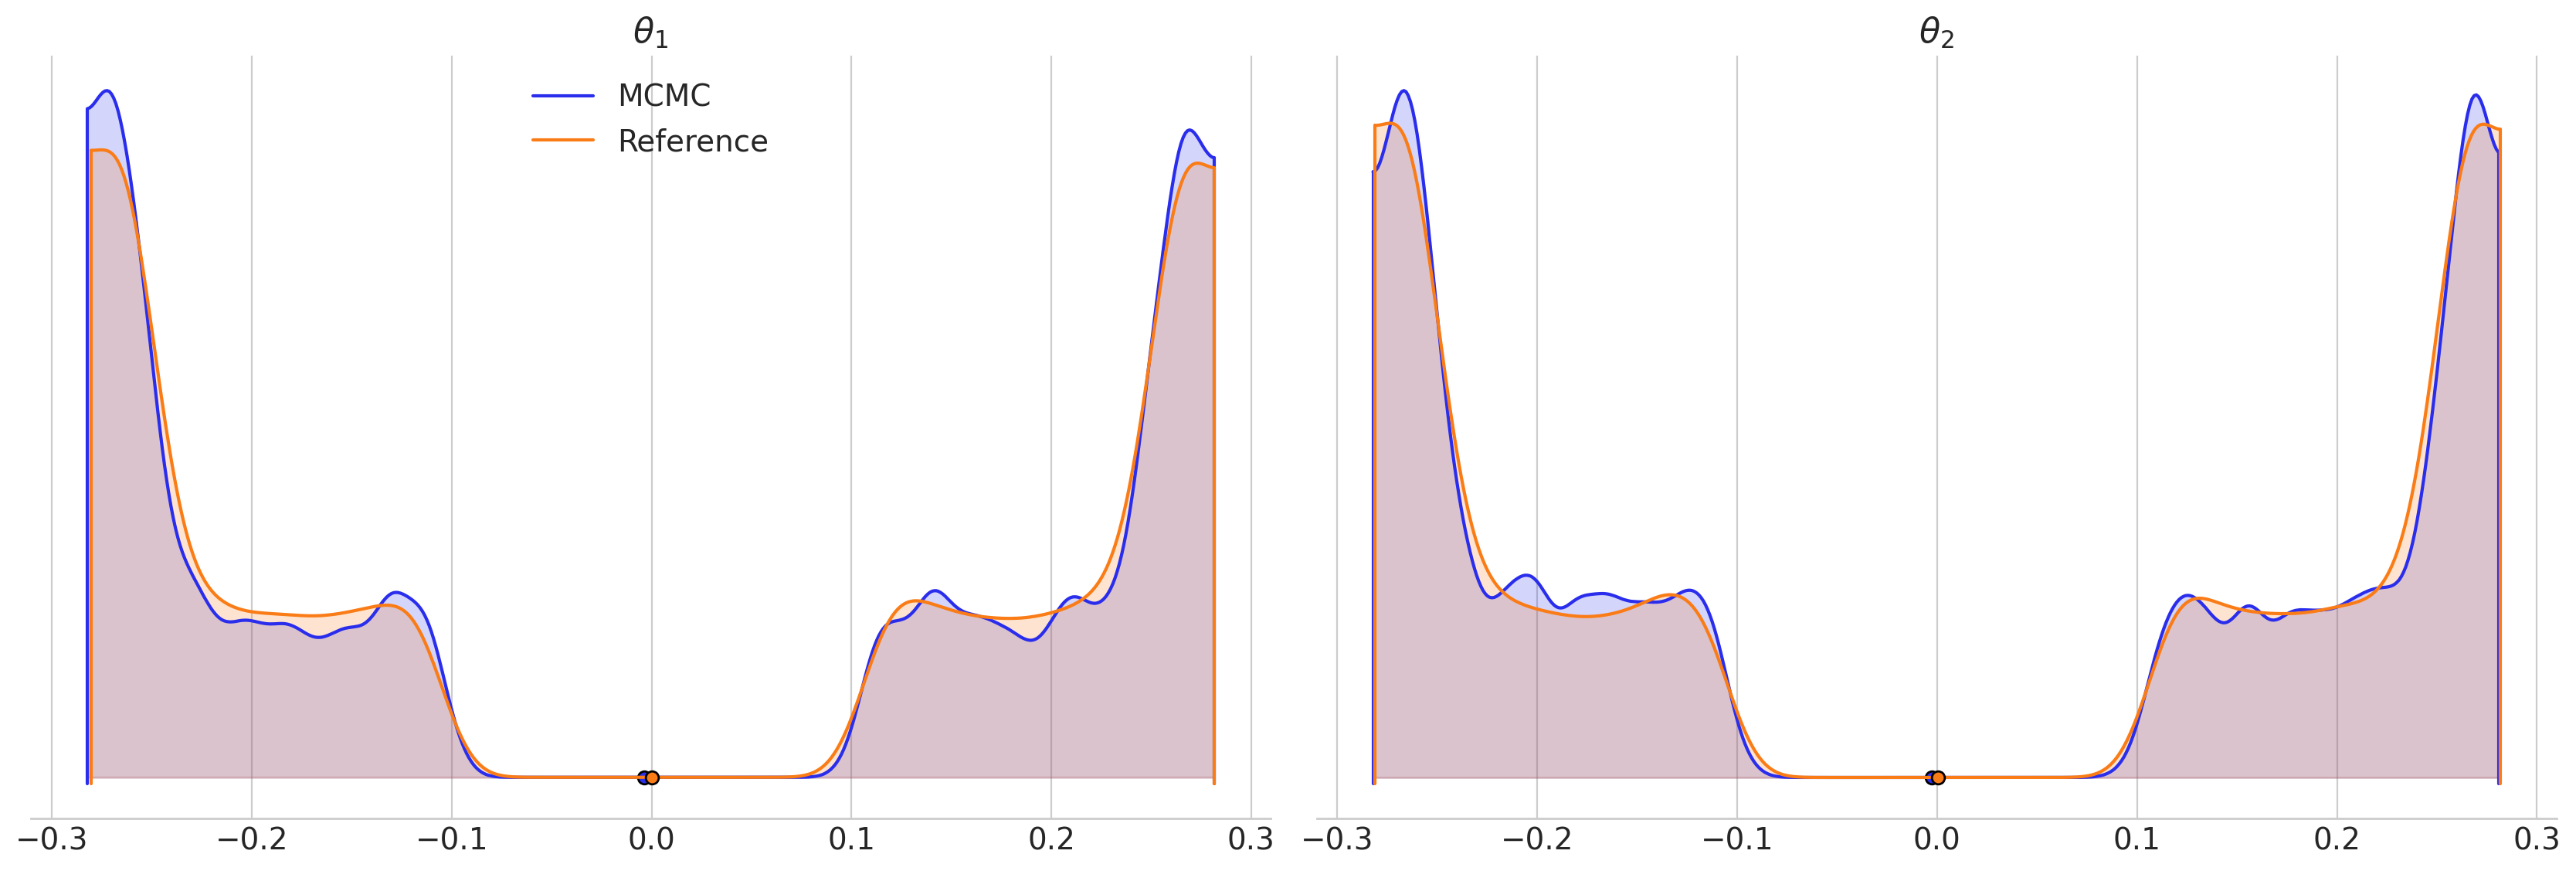

In [13]:
def compare_marginals(target_data: dict, data_label: str):
    az.plot_density(
        [target_data, data_from_true_samples],
        data_labels=[data_label, "Reference"],
        var_names=labels,
        shade=0.2,
    )


compare_marginals(data_from_mcmc_trimmed, "MCMC")

## Using SBI

We will use `SNPE` and `SRE` in this benchmark.

### NPE and SNPE

In [14]:
npe = SNPERunner(benchmark=two_moons, seed=seed, density_estimator="nsf")

In [15]:
num_simulations = 16384
num_samples = 16384
x0 = torch.zeros(2)

In [16]:
training_kwargs = {
    "show_train_summary": True,
    "training_batch_size": 128,
    "use_combined_loss": True,
    "learning_rate": 2e-4,
}
truncate_at = 1e-4

In [17]:
%%time

npe.train(
    num_simulations, x_0=x0, training_kwargs=training_kwargs, truncate_at=truncate_at
)

Running 16384 simulations.:   0%|          | 0/16384 [00:00<?, ?it/s]

 Neural network successfully converged after 169 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 169
        Best validation performance: 3.5672
        -------------------------
        


Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

/Users/bernardoveronese/miniconda3/envs/sbibench/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2198.)
  outputs, _ = torch.triangular_solve(


CPU times: user 23min 28s, sys: 35.1 s, total: 24min 3s
Wall time: 12min 27s


(DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>,
 NFlowsFlow(
   (net): Flow(
     (_transform): CompositeTransform(
       (_transforms): ModuleList(
         (0): AffineTransform()
         (1): PiecewiseRationalQuadraticCouplingTransform(
           (transform_net): ResidualNet(
             (initial_layer): Linear(in_features=3, out_features=50, bias=True)
             (blocks): ModuleList(
               (0-1): 2 x ResidualBlock(
                 (context_layer): Linear(in_features=2, out_features=50, bias=True)
                 (linear_layers): ModuleList(
                   (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
                 )
                 (dropout): Dropout(p=0.0, inplace=False)
               )
             )
             (final_layer): Linear(in_features=50, out_features=29, bias=True)
           )
         )
         (2): LULinear()
         (3): PiecewiseRationalQuadraticCouplingTransform(
           (transform_net): Residu

Drawing 16384 posterior samples:   0%|          | 0/16384 [00:00<?, ?it/s]

array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

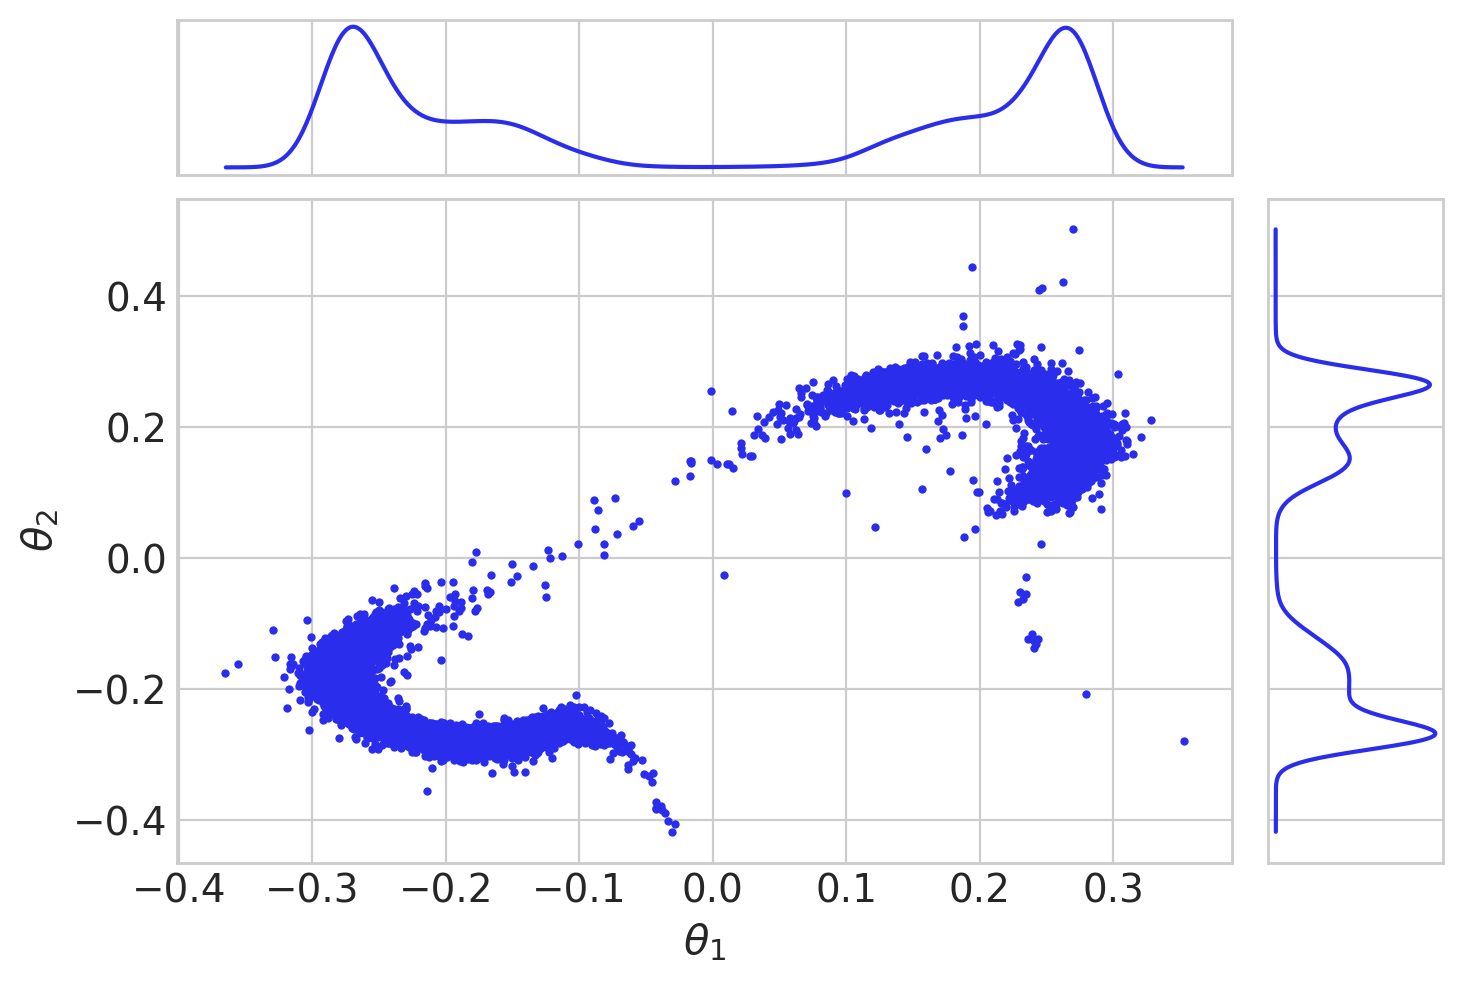

In [19]:
samples_from_npe = npe.sample(num_samples, x=x0)
data_from_npe = get_data(samples_from_npe.unsqueeze(0))
az.plot_pair(data_from_npe, var_names=labels, marginals=True)

While NPE reconstructs the general shape of the posterior to a certain degree, we also observe leakage to regions outside the posterior support. This is a known problem with NPE.

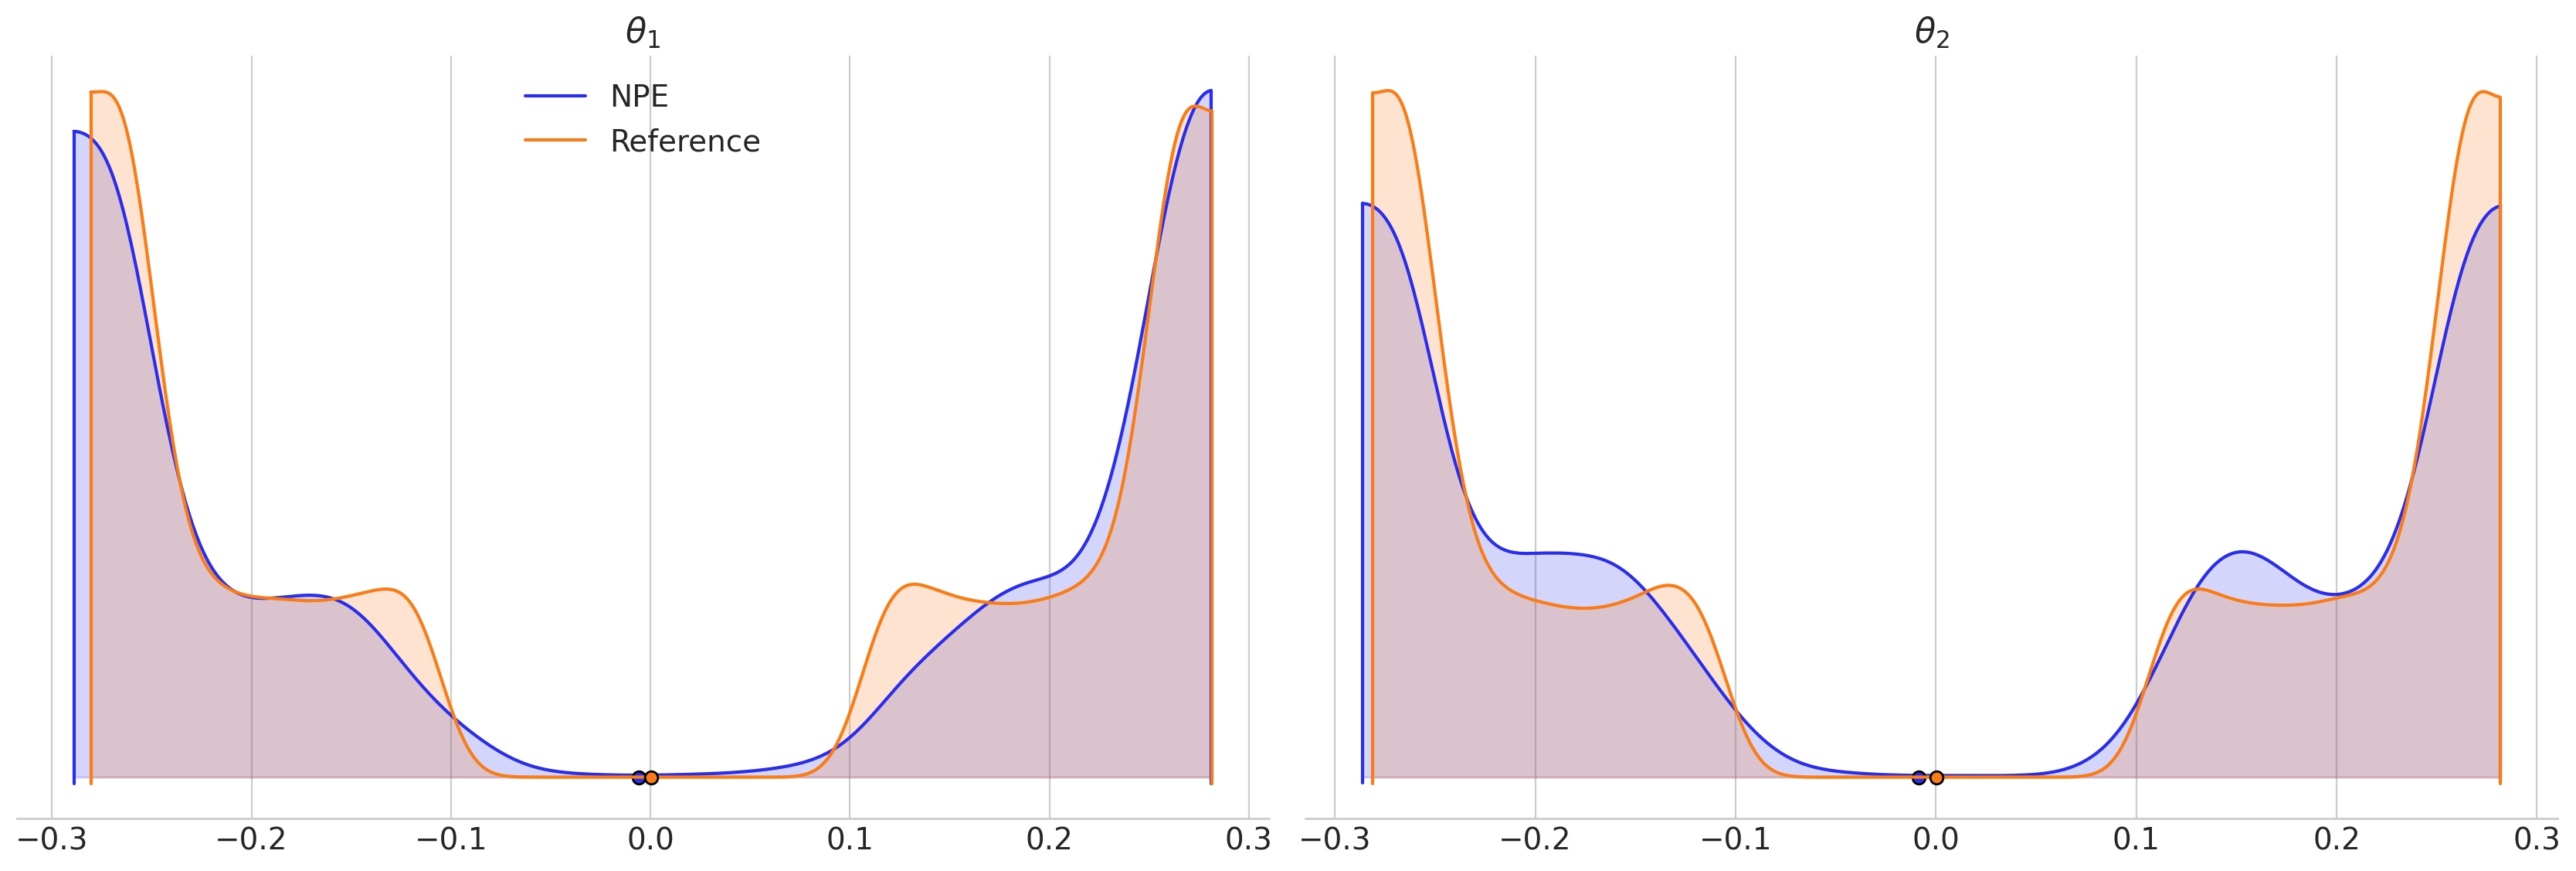

In [20]:
compare_marginals(data_from_npe, "NPE")

Let us try the sequential version, SNPE:

In [21]:
snpe = SNPERunner(benchmark=two_moons, seed=seed, density_estimator="nsf")
num_rounds = 4

In [22]:
%%time

snpe.train(num_simulations, num_rounds=3, x_0=x0, training_kwargs=training_kwargs)

Running 5461 simulations.:   0%|          | 0/5461 [00:00<?, ?it/s]

 Neural network successfully converged after 150 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 150
        Best validation performance: 3.3922
        -------------------------
        


Drawing 5461 posterior samples:   0%|          | 0/5461 [00:00<?, ?it/s]

Running 5461 simulations.:   0%|          | 0/5461 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 78 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 78
        Best validation performance: 1.4137
        -------------------------
        


Drawing 5461 posterior samples:   0%|          | 0/5461 [00:00<?, ?it/s]

Running 5461 simulations.:   0%|          | 0/5461 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 23
        Best validation performance: 0.6832
        -------------------------
        
CPU times: user 32min 30s, sys: 1min 57s, total: 34min 28s
Wall time: 17min 39s


(DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>,
 NFlowsFlow(
   (net): Flow(
     (_transform): CompositeTransform(
       (_transforms): ModuleList(
         (0): AffineTransform()
         (1): PiecewiseRationalQuadraticCouplingTransform(
           (transform_net): ResidualNet(
             (initial_layer): Linear(in_features=3, out_features=50, bias=True)
             (blocks): ModuleList(
               (0-1): 2 x ResidualBlock(
                 (context_layer): Linear(in_features=2, out_features=50, bias=True)
                 (linear_layers): ModuleList(
                   (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
                 )
                 (dropout): Dropout(p=0.0, inplace=False)
               )
             )
             (final_layer): Linear(in_features=50, out_features=29, bias=True)
           )
         )
         (2): LULinear()
         (3): PiecewiseRationalQuadraticCouplingTransform(
           (transform_net): Residu

Drawing 16384 posterior samples:   0%|          | 0/16384 [00:00<?, ?it/s]

array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

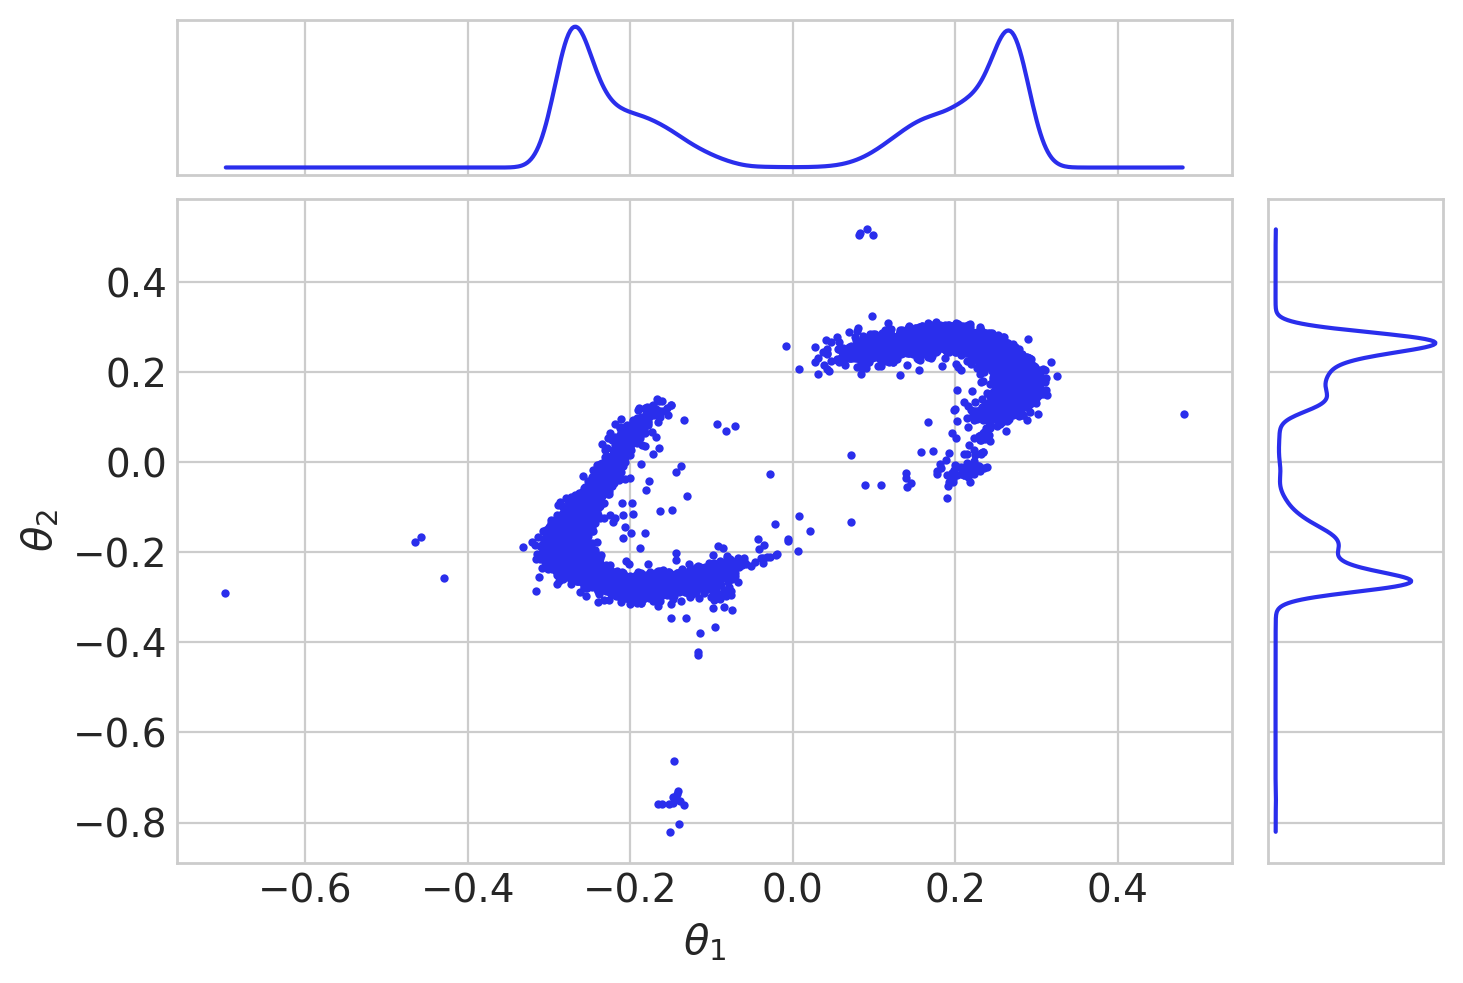

In [23]:
samples_from_snpe = snpe.sample(num_samples, x=x0)
data_from_snpe = get_data(samples_from_snpe.unsqueeze(0))
az.plot_pair(data_from_snpe, var_names=labels, marginals=True)

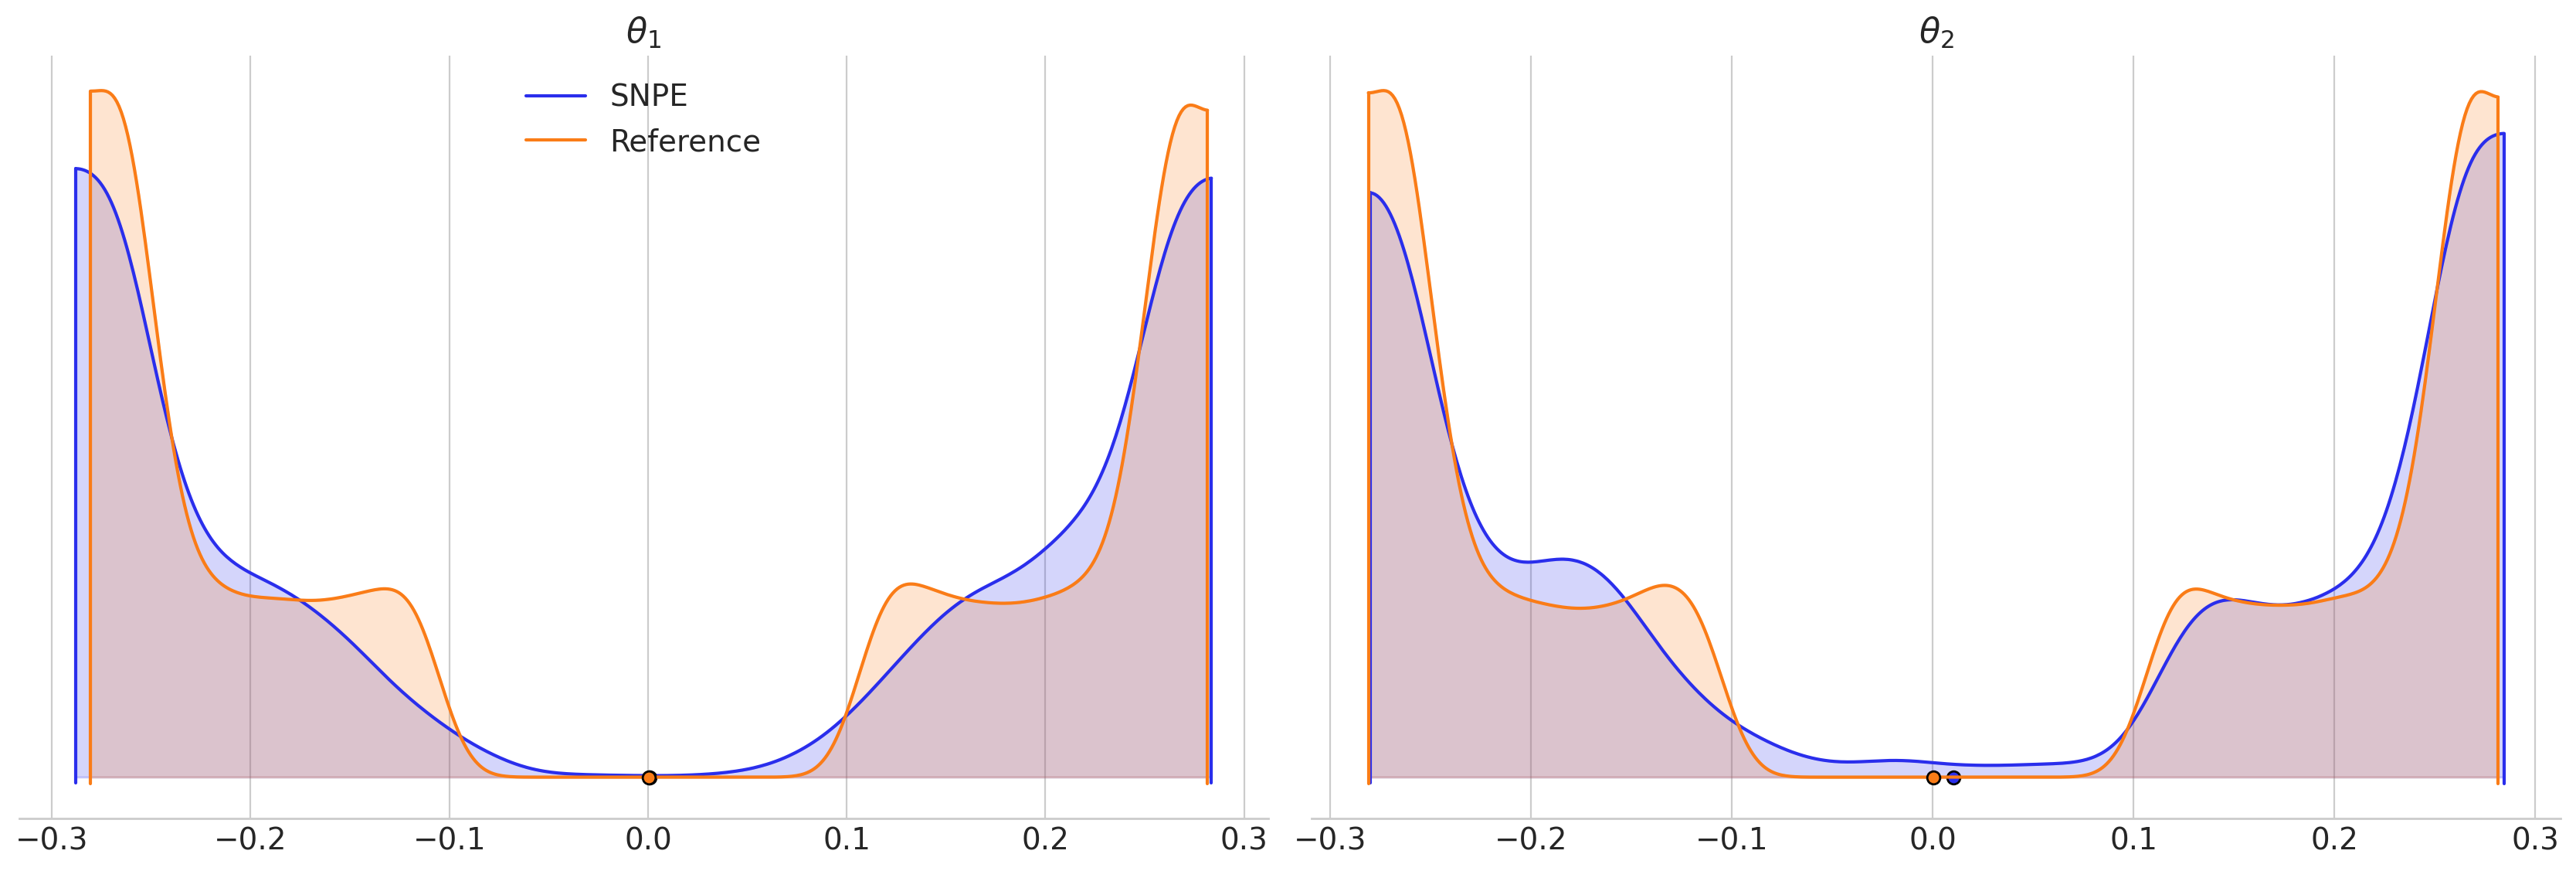

In [24]:
compare_marginals(data_from_snpe, "SNPE")

Qualitatively, SNPE seems to perform worse than its non-sequential counterpart. Indeed, it is not always that case that sequential variants are more performant [1].

### NRE and SNRE

We first train 1 round of NRE, and generate samples using MCMC. Since the two posterior modes are far away from each other, we use multiple chains to avoid covering only one mode.

We also experiment with different training hyperparameters.

In [25]:
nre = SNRERunner(benchmark=two_moons, seed=seed)

mcmc_kwargs = {
    "mcmc_method": "slice_np_vectorized",
    "mcmc_parameters": {"num_chains": 50},
}
training_kwargs = {
    "show_train_summary": True,
    "training_batch_size": 128,
    "learning_rate": 2e-4,
}

In [26]:
%%time

nre.train(
    num_simulations, training_kwargs=training_kwargs, posterior_kwargs=mcmc_kwargs
)

Running 16384 simulations.:   0%|          | 0/16384 [00:00<?, ?it/s]

 Neural network successfully converged after 98 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 98
        Best validation performance: -0.0006
        -------------------------
        
CPU times: user 5min 16s, sys: 3.36 s, total: 5min 19s
Wall time: 2min 46s


/Users/bernardoveronese/miniconda3/envs/sbibench/lib/python3.10/site-packages/sbi/inference/posteriors/mcmc_posterior.py:114: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


(MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 Sequential(
   (0): StandardizeInputs(
     (embedding_net_x): Sequential(
       (0): Standardize()
       (1): Identity()
     )
     (embedding_net_y): Sequential(
       (0): Standardize()
       (1): Identity()
     )
   )
   (1): ResidualNet(
     (initial_layer): Linear(in_features=4, out_features=50, bias=True)
     (blocks): ModuleList(
       (0-1): 2 x ResidualBlock(
         (linear_layers): ModuleList(
           (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
         )
         (dropout): Dropout(p=0.0, inplace=False)
       )
     )
     (final_layer): Linear(in_features=50, out_features=1, bias=True)
   )
 ))

Running vectorized MCMC with 50 chains:   0%|          | 0/26400 [00:00<?, ?it/s]

array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

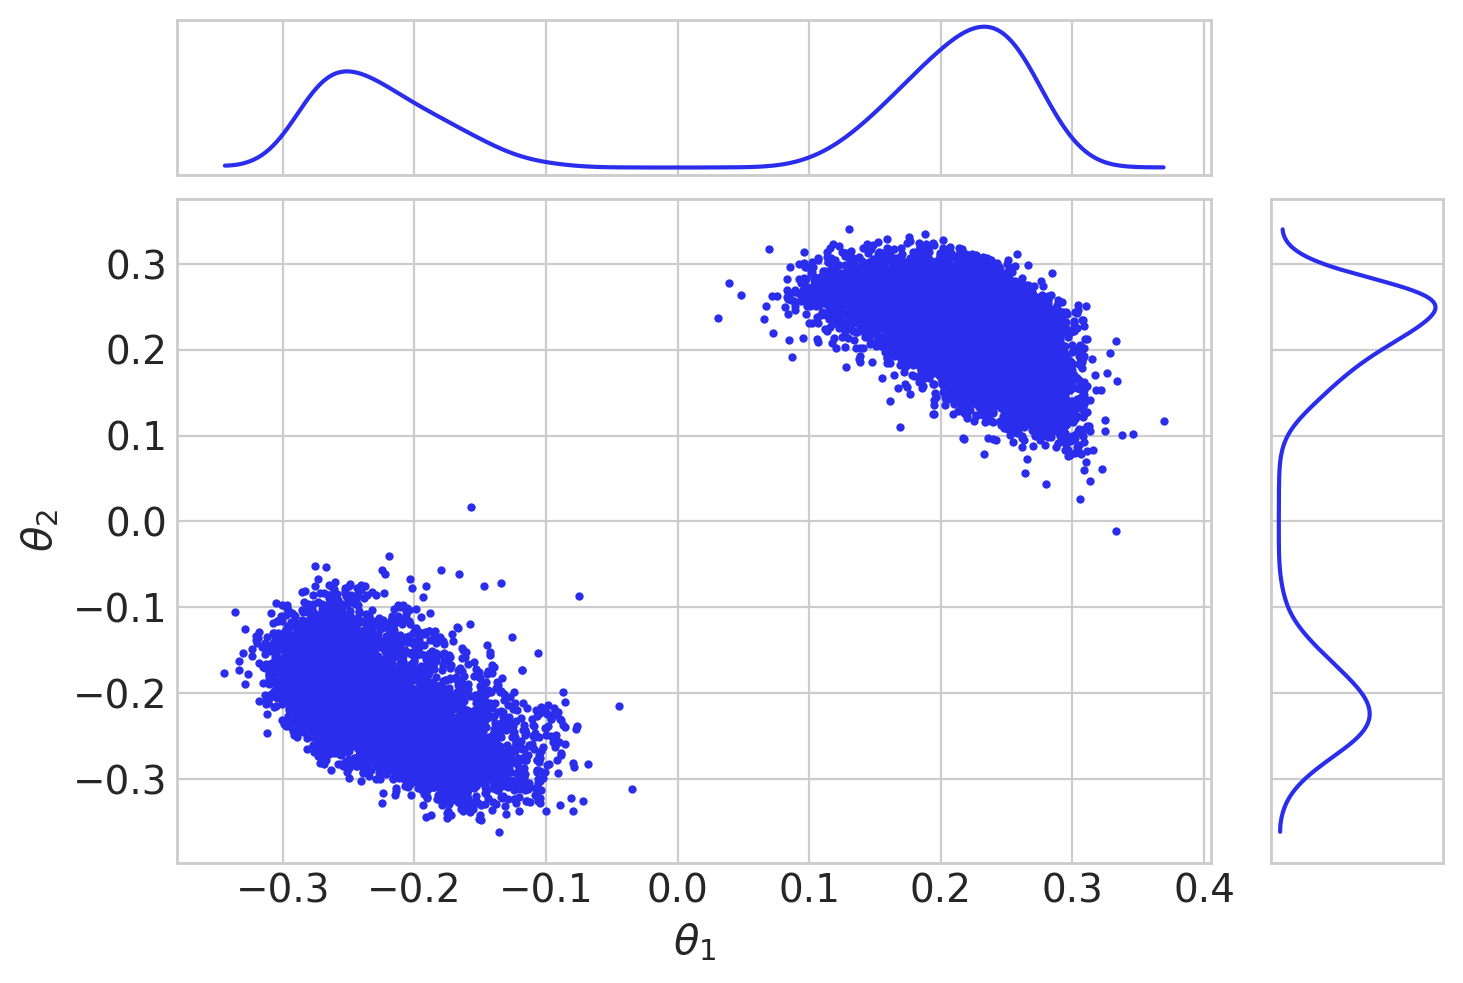

In [27]:
samples_from_nre = nre.sample(num_samples, x=x0)
data_from_nre = get_data(samples_from_nre.unsqueeze(0))
az.plot_pair(data_from_nre, var_names=labels, marginals=True)

NRE seems to display less leakage compared to NPE, but the shapes of the moons are not well resolved. We also observe an asymmetry in the peak heights of the 1D marginals. Could it be corrected for with a better tuned MCMC?

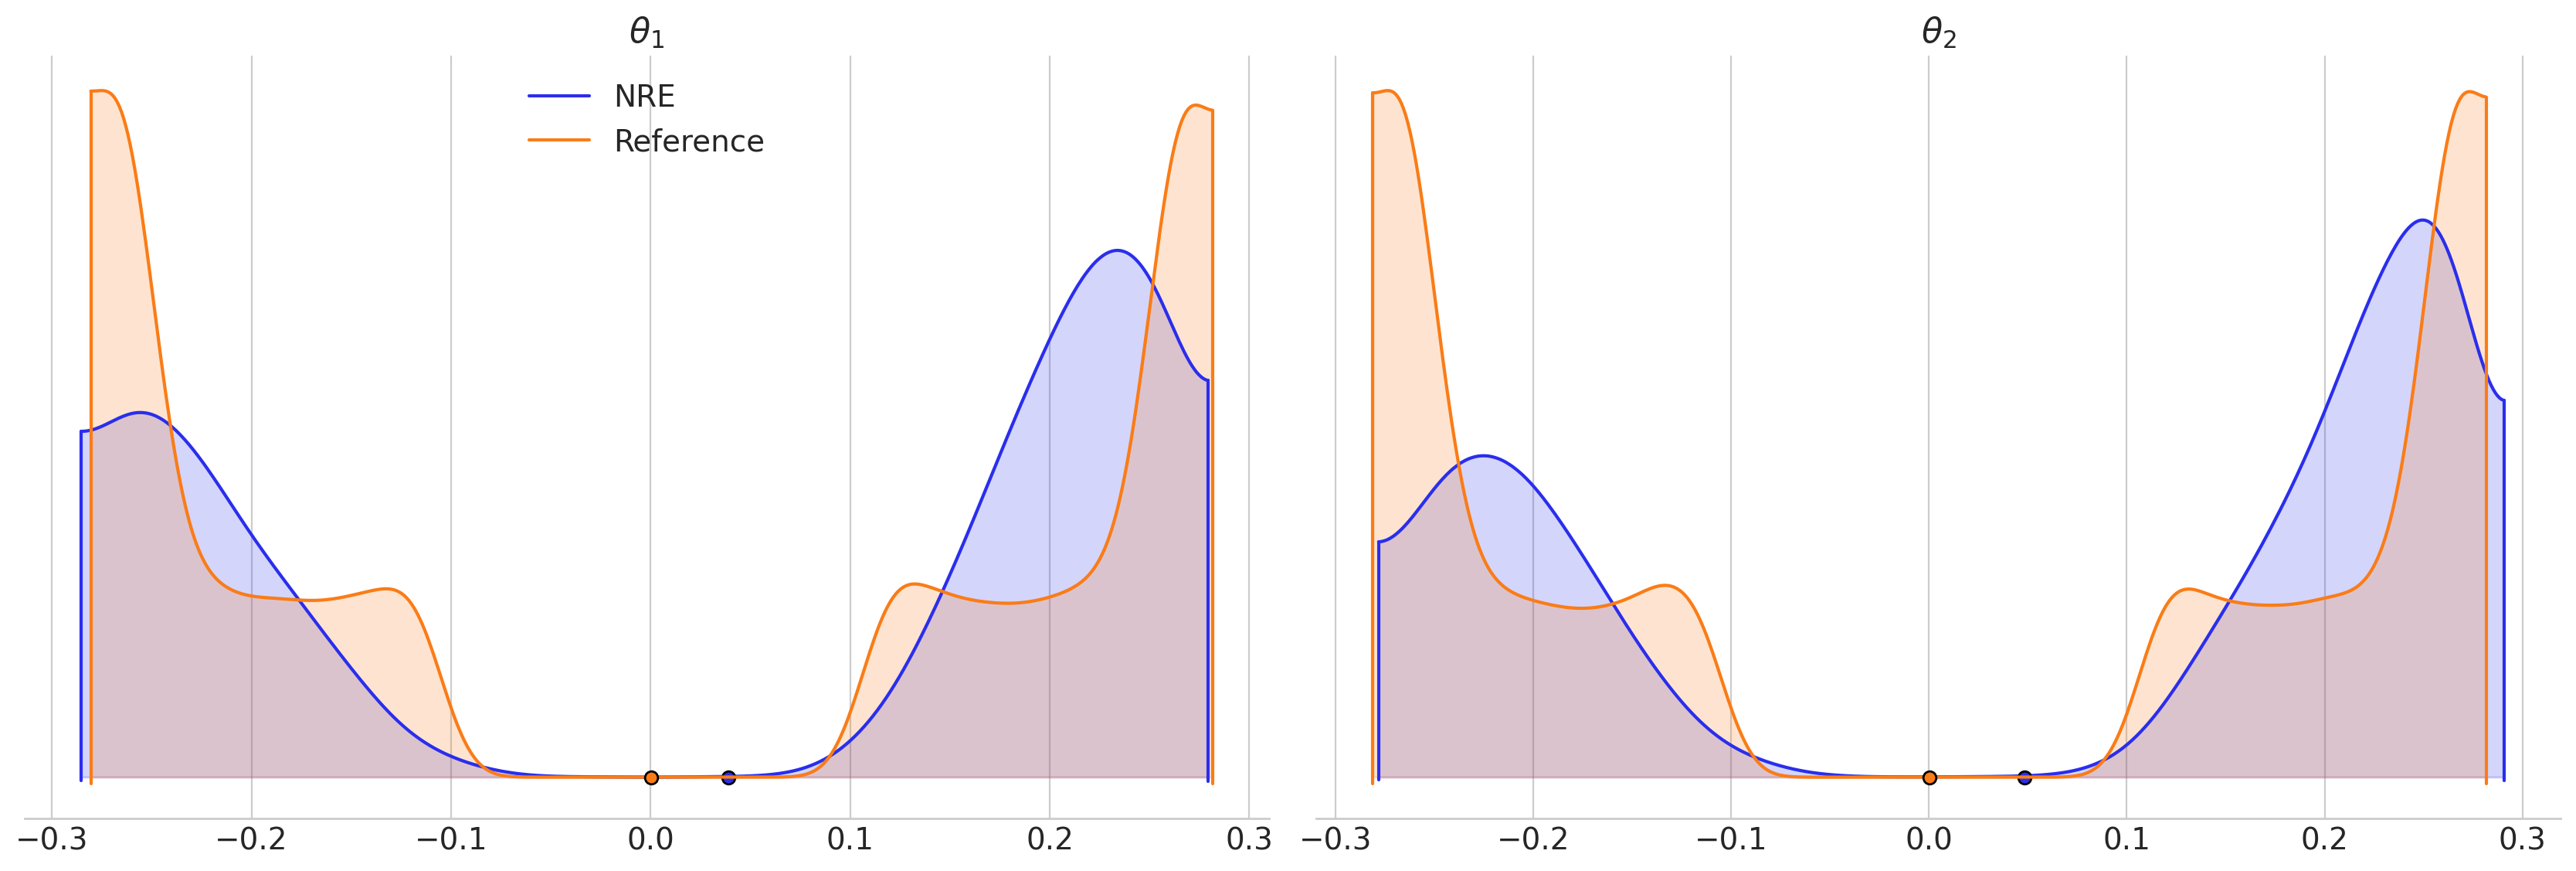

In [28]:
compare_marginals(data_from_nre, "NRE")

 Let us try the sequential variant next. We decide on a number of rounds and split the simulation budget equally between them.

In [29]:
snre = SNRERunner(benchmark=two_moons, seed=seed)
num_rounds = 4

In [30]:
%%time

snre.train(
    num_simulations,
    num_rounds=4,
    x_0=x0,
    training_kwargs=training_kwargs,
    posterior_kwargs=mcmc_kwargs,
)

Running 4096 simulations.:   0%|          | 0/4096 [00:00<?, ?it/s]

 Neural network successfully converged after 77 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 77
        Best validation performance: -0.0005
        -------------------------
        


Running vectorized MCMC with 50 chains:   0%|          | 0/14100 [00:00<?, ?it/s]

Running 4096 simulations.:   0%|          | 0/4096 [00:00<?, ?it/s]

 Neural network successfully converged after 76 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 76
        Best validation performance: -0.0030
        -------------------------
        


Running vectorized MCMC with 50 chains:   0%|          | 0/14100 [00:00<?, ?it/s]

Running 4096 simulations.:   0%|          | 0/4096 [00:00<?, ?it/s]

 Neural network successfully converged after 59 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 59
        Best validation performance: -0.0045
        -------------------------
        


Running vectorized MCMC with 50 chains:   0%|          | 0/14100 [00:00<?, ?it/s]

Running 4096 simulations.:   0%|          | 0/4096 [00:00<?, ?it/s]

 Neural network successfully converged after 30 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 30
        Best validation performance: -0.0052
        -------------------------
        
CPU times: user 6min 39s, sys: 5.12 s, total: 6min 44s
Wall time: 3min 30s


(MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 Sequential(
   (0): StandardizeInputs(
     (embedding_net_x): Sequential(
       (0): Standardize()
       (1): Identity()
     )
     (embedding_net_y): Sequential(
       (0): Standardize()
       (1): Identity()
     )
   )
   (1): ResidualNet(
     (initial_layer): Linear(in_features=4, out_features=50, bias=True)
     (blocks): ModuleList(
       (0-1): 2 x ResidualBlock(
         (linear_layers): ModuleList(
           (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
         )
         (dropout): Dropout(p=0.0, inplace=False)
       )
     )
     (final_layer): Linear(in_features=50, out_features=1, bias=True)
   )
 ))

We see that the total training times are similar in order of magnitude; the sequential version trains for more rounds but uses less data per round.

Running vectorized MCMC with 50 chains:   0%|          | 0/26400 [00:00<?, ?it/s]

array([[<Axes: >, None],
       [<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>, <Axes: >]],
      dtype=object)

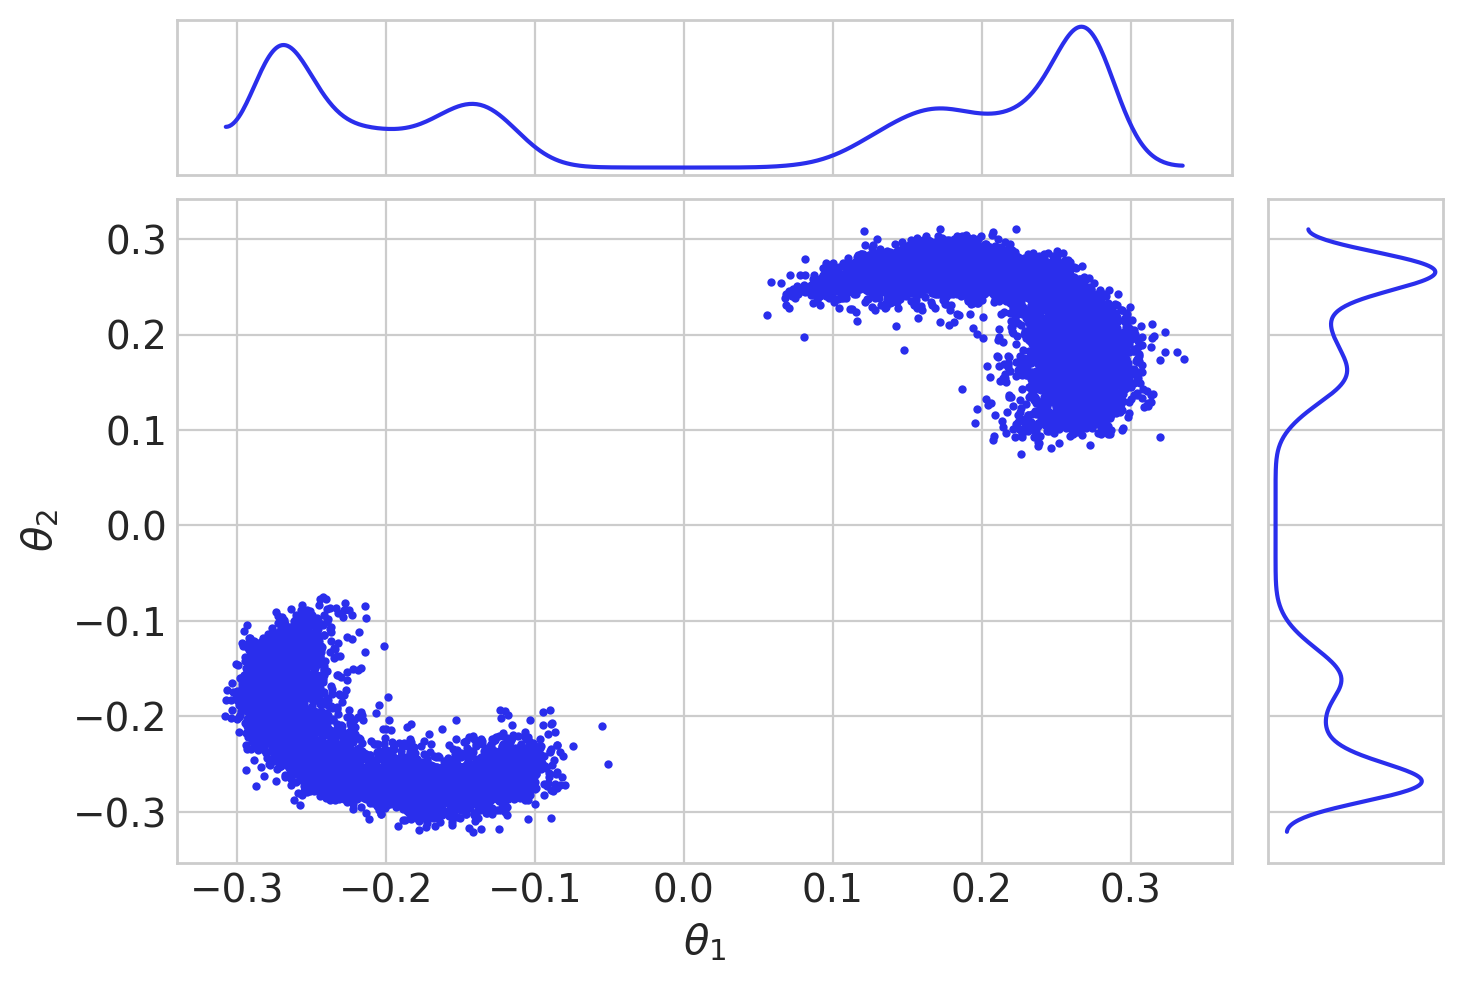

In [31]:
samples_from_snre = snre.sample(num_samples, x=x0)
data_from_snre = get_data(samples_from_snre.unsqueeze(0))
az.plot_pair(data_from_snre, var_names=labels, marginals=True)

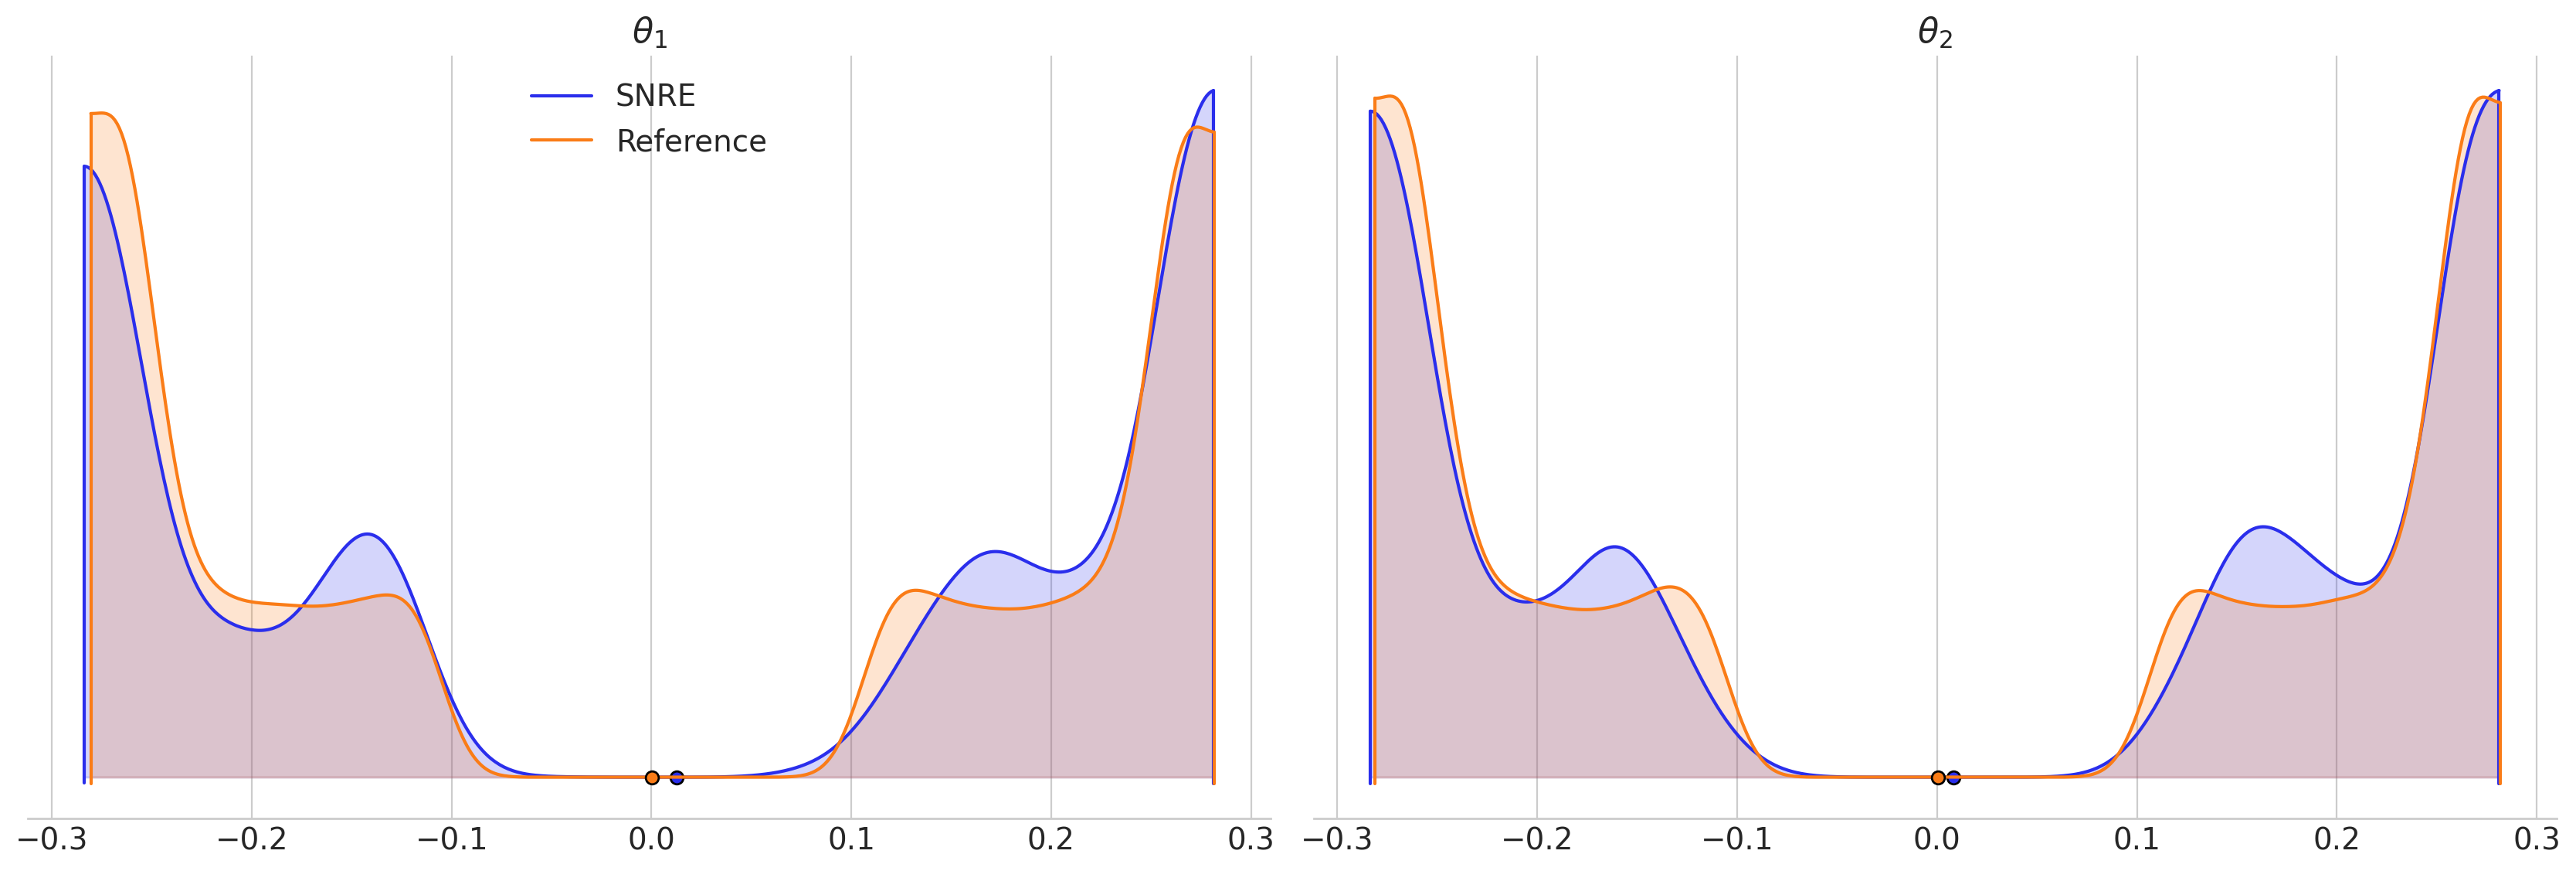

In [32]:
compare_marginals(data_from_snre, "SNRE")

The sequential variant here does improve the results, with better resolution of the shapes of the moons and a less siginificant assymetry in the marginals.

The take-home message of this tutorial is that, much like MCMC, it is important to play around with different strategies and hyperparameters, which may have a high impact on performance. There is no ultimate algorithm that consistently performs better than the rest across different tasks.

## References

[1]: Hermans, Joeri, et al. "A trust crisis in simulation-based inference? your posterior approximations can be unfaithful." arXiv preprint arXiv:2110.06581 (2021).

[2]: Lueckmann, Jan-Matthis, et al. "Benchmarking simulation-based inference." International conference on artificial intelligence and statistics. PMLR, 2021.